In [1]:
import copy
import os
from typing import Any

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import pyref.fitting as fit
from matplotlib.figure import Figure
from refnx.analysis import Transform

CPU_COUNT = os.cpu_count()

# Load the Data Files


Dataset loaded from reflectivity_data.parquet


(<Axes: ylabel='$R$'>, <Axes: xlabel='$q (\\AA^{-1})$'>)

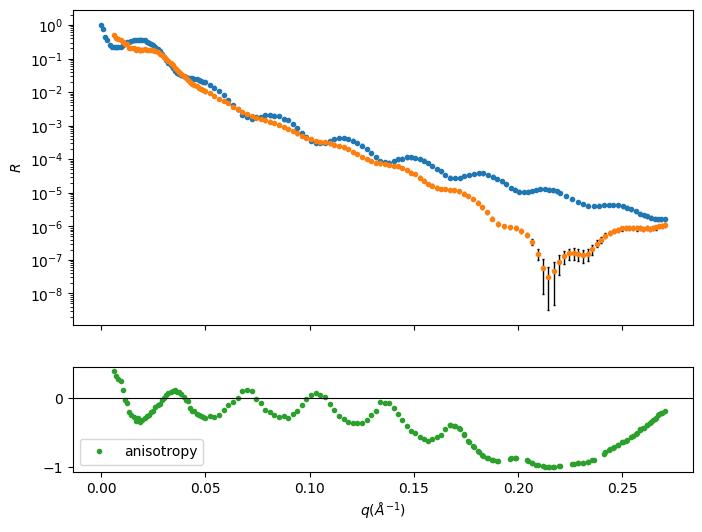

In [2]:
def load_reflectivity_dataset(filename):
    """
    Load reflectivity dataset from a parquet file.

    Parameters
    ----------
    filename : str
        Input filename (should be a .parquet file)

    Returns
    -------
    dict
        Dictionary containing XrayReflectDataset objects with energy keys
    """
    # Load the DataFrame
    df_load = pl.read_parquet(filename)

    # Reconstruct the data dictionary
    data_reconstructed = {}

    # Group by energy
    for group_key, group_data in df_load.group_by("energy"):
        energy_val = group_key[0]  # Extract energy value from the group key tuple

        # Extract arrays
        Q = group_data["Q"].to_numpy()
        R = group_data["R"].to_numpy()
        dR = group_data["dR"].to_numpy()

        # Create XrayReflectDataset
        dataset = fit.XrayReflectDataset(data=(Q, R, dR))
        data_reconstructed[str(energy_val)] = dataset

    print(f"Dataset loaded from {filename}")
    return data_reconstructed


# # Save the dataset to a parquet file
# save_reflectivity_dataset(data, "reflectivity_data.parquet")
# # Load the dataset back from the parquet file
loaded_data = load_reflectivity_dataset("reflectivity_data.parquet")
loaded_data["283.7"].plot(label="283.7 eV data")

# Load Optical Constants for Constraints and OOC instantiation


In [3]:
import pickle

ooc = pd.read_csv("optical_constants.csv")
energy = [float(e) for e in loaded_data.keys()]
with open("fitting_results_fixed.pkl", "rb") as f:
    fitting_results = pickle.load(f)


def get_objective_at_energy(global_objective, energy):
    """
    Retrieve the GlobalObjective object for a specific energy from fitting results.

    Parameters
    ----------
    fitting_results : dict
        Dictionary containing fitting results with energy keys.
    energy : float
        The energy value for which to retrieve the GlobalObjective.

    Returns
    -------
    GlobalObjective
        The GlobalObjective object corresponding to the specified energy.
    """
    for o in global_objective.objectives:
        if np.isclose(o.model.energy, energy):
            return o
    raise ValueError(f"No objective found for energy {energy}")


def get_optical_constants(objective):
    """
    Extract optical constants from a GlobalObjective object for a specific energy.

    Parameters
    ----------
    global_objective : GlobalObjective
        The GlobalObjective object containing the fitting results.
    energy : float
        The energy value for which to extract the optical constants.

    Returns
    -------
    tuple
        A tuple containing (delta, beta) for the specified energy.
    """
    sld_spec = {
        "density": [],
        "rotation": [],
        "energy_offset": [],
        "tensor": [],
        "thickness": [],
        "roughness": [],
    }
    structure = objective.model.structure
    for layer in structure:
        sld = layer.sld
        sld_spec["density"].append(sld.density.value)
        sld_spec["rotation"].append(sld.rotation.value)
        sld_spec["energy_offset"].append(sld.energy_offset.value)
        tensor = sld.tensor
        sld_spec["tensor"].append(tensor)
        sld_spec["thickness"].append(layer.thick.value)
        sld_spec["roughness"].append(layer.rough.value)
    return sld_spec


slds = {}
for o in fitting_results.objectives:
    e = o.model.energy
    sld_spec = get_optical_constants(o)
    slds[str(e)] = sld_spec
slds

{'250.0': {'density': [np.float64(0.0),
   np.float64(1.4655185072454873),
   np.float64(1.6536033989187757),
   np.float64(1.8),
   np.float64(2.145078869107535),
   np.float64(2.4432714412232603)],
  'rotation': [np.float64(0.0),
   np.float64(0.8015911159304013),
   np.float64(1.2069625690959114),
   np.float64(0.9036337915490659),
   np.float64(0.0),
   np.float64(0.0)],
  'energy_offset': [np.float64(-0.0017356089472281649),
   np.float64(-0.0017356089472281649),
   np.float64(-0.0017356089472281649),
   np.float64(-0.0017356089472281649),
   np.float64(-0.0017356089472281649),
   np.float64(-0.0017356089472281649)],
  'tensor': [array([[0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j]]),
   array([[0.00275385+0.00035459j, 0.        +0.j        ,
           0.        +0.j        ],
          [0.        +0.j        , 0.00275385+0.00035459j,
           0.        +0.j        ],
          [0.        +0.j        , 0.        +0.j        ,
 

In [4]:
with open("slds_dict.pkl", "wb") as f:
    pickle.dump(slds, f)
print("slds dictionary saved to slds_dict.pkl")

slds dictionary saved to slds_dict.pkl


In [5]:
with open("slds_dict.pkl", "rb") as f:
    slds = pickle.load(f)

In [6]:
ZNPC = "C32H16N8Zn"
MA = np.asin(np.sqrt(2 / 3))


def vacuum(energy):
    """Vacuum."""
    slab = fit.MaterialSLD("", 0, name=f"Vacuum_{energy}")(0, 0)
    slab.thick.setp(vary=False)
    slab.rough.setp(vary=False)
    slab.sld.density.setp(vary=False)
    return slab


def substrate(energy, thick=0, rough=1.2, density=2.329):
    """Substrate."""
    slab = fit.MaterialSLD(
        "Si", density=density, energy=energy, name=f"Substrate_{energy}"
    )(thick, rough)
    slab.thick.setp(vary=False)
    slab.rough.setp(vary=False)
    slab.sld.density.setp(vary=True, bounds=(2, 3))
    return slab


def sio2(energy, thick=8.22, rough=6.153, density=2.196):
    """SiO2."""
    slab = fit.MaterialSLD(
        "SiO2", density=density, energy=energy, name=f"Oxide_{round(energy, 1)}"
    )(thick, rough)
    slab.thick.setp(vary=True, bounds=(0, 25))
    slab.rough.setp(vary=True, bounds=(0, 8))
    slab.sld.density.setp(vary=True, bounds=(2.0, 3))
    return slab


def contamination(energy, thick=4.4, rough=2, density=1.0):
    """Contamination."""
    name = f"Contamination_{energy}"
    slab = fit.UniTensorSLD(
        ooc, density=density, rotation=MA, energy=energy, name=name
    )(thick, rough)
    slab.sld.density.setp(vary=True, bounds=(0.5, 3))
    slab.sld.rotation.setp(vary=True, bounds=(0, np.pi / 2))

    slab.thick.setp(vary=True, bounds=(0, 30))
    slab.rough.setp(vary=True, bounds=(0, 25))
    return slab


def surface(energy, thick=3.3, rough=1, density=1.0):
    """Surface."""
    name = f"Surface_{energy}"
    slab = fit.UniTensorSLD(
        ooc, density=density, rotation=MA, energy=energy, name=name
    )(thick, rough)
    slab.sld.density.setp(vary=True, bounds=(0.5, 3))
    slab.sld.rotation.setp(vary=True, bounds=(0, np.pi / 2))

    slab.thick.setp(vary=True, bounds=(0, 30))
    slab.rough.setp(vary=True, bounds=(0, 25))
    return slab


def znpc(energy, thick=191, rough=8.8, density=1.61):
    """ZnPc."""
    name = f"ZnPc_{energy}"
    slab = fit.UniTensorSLD(
        ooc, density=density, rotation=1.35, energy=energy, name=name
    )(thick, rough)
    slab.sld.density.setp(vary=True, bounds=(1.0, 2))
    if energy == 250.0:
        slab.sld.rotation.setp(vary=False, value=MA)
    else:
        slab.sld.rotation.setp(vary=True, bounds=(0, np.pi / 2))

    slab.thick.setp(vary=True, bounds=(100, 210))
    slab.rough.setp(vary=True, bounds=(0, 25))
    return slab


def construct_slab(
    energy,
    offset=0,
):
    """Construct the slab."""
    offset_energy = energy  # round(energy + offset, 1)
    slab = (
        vacuum(offset_energy)
        | surface(offset_energy)
        | znpc(offset_energy)
        | contamination(offset_energy)
        | sio2(offset_energy)
        | substrate(offset_energy)
    )
    slab.name = f"Monolayer_{energy + offset}"
    return slab

    return slab


stacks = {str(round(e, 1)): construct_slab(e) for e in energy}
struct_stacks = {str(round(e, 1)): construct_slab(e) for e in [283.7, 250.0]}
stacks.keys()

dict_keys(['282.9', '281.6', '281.4', '283.5', '289.0', '282.0', '282.3', '275.0', '284.2', '282.7', '285.1', '281.2', '283.3', '287.0', '281.8', '280.0', '283.7', '282.5', '250.0', '283.1', '281.0'])

In [7]:
print(struct_stacks["283.7"])

________________________________________________________________________________
Structure: Monolayer_283.7
reverse structure: False
________________________________________________________________________________
Parameters: 'Vacuum_283.7' 
________________________________________________________________________________
Parameters: 'Vacuum_283.7_slab'
<Parameter:'Vacuum_283.7_thick', value=0  (fixed) , bounds=[0.0, 0.0]>
<Parameter:'Vacuum_283.7_rough', value=0  (fixed) , bounds=[0.0, 0.0]>
<Parameter:'Vacuum_283.7_rho', value=0  (fixed) , bounds=[0.0, 0.0]>
<Parameter:'Vacuum_283.7_energy_offset', value=0          , bounds=[-1.0, 1.0]>
________________________________________________________________________________
Parameters: 'Surface_283.7'
________________________________________________________________________________
Parameters: 'Surface_283.7_slab'
<Parameter:'Surface_283.7_thick', value=3.3          , bounds=[0.0, 30.0]>
<Parameter:'Surface_283.7_rough', value=1          , bou

In [8]:
def safely_setp(slab, param, **kwargs):
    """Safely set parameters."""
    #  Check if the vary = True while the constraint is not None
    if kwargs.get("vary", False) and kwargs.get("constraint") is not None:
        kwargs["vary"] = None
    if hasattr(slab, param):
        getattr(slab, param).setp(**kwargs)

In [9]:
def constrain_parameters(base_energy: float, stacks=stacks, energy=energy):
    """
    Constrains the structural parameters of all energy stacks to a base energy stack.

    Parameters
    ----------
    base_energy : float
        The energy of the stack to use as the constraint source.
    stacks : dict
        Dictionary of energy stacks.
    energy : list
        List of energy values.
    """
    base_stack = stacks[str(round(base_energy, 1))]
    for e in energy:
        if np.isclose(e, base_energy):
            continue

        current_stack = stacks[str(round(e, 1))]
        for i, slab in enumerate(current_stack):
            safely_setp(
                slab,
                "thick",
                vary=None,
                constraint=base_stack[i].thick,
            )
            safely_setp(
                slab,
                "rough",
                vary=None,
                constraint=base_stack[i].rough,
            )
            # Constrain density and rotation for the first and last layers
            if i == 0 or i == len(current_stack) - 1:
                safely_setp(
                    slab.sld,
                    "density",
                    vary=None,
                    constraint=base_stack[i].sld.density,
                )
                safely_setp(
                    slab.sld,
                    "rotation",
                    vary=None,
                    constraint=base_stack[i].sld.rotation,
                )

In [10]:
def setp_scales(model, **kwargs):
    model.scale_p.setp(bounds=(0.6, 1.4), **kwargs)
    model.scale_s.setp(bounds=(0.6, 1.4), **kwargs)


def setp_offsets(model, **kwargs):
    model.theta_offset_p.setp(bounds=(-0.5, 0.5), **kwargs)
    model.theta_offset_s.setp(bounds=(-0.5, 0.5), **kwargs)


def create_models(energies, stacks):
    #  Constrain the structural parameters across all stacks
    models = {
        str(e): fit.ReflectModel(
            stacks[str(round(e, 1))], pol="sp", name="Model " + str(e), energy=e
        )
        for e in energies
    }
    for name, model in models.items():
        if float(name) not in [250, 283.7]:
            model.bkg = 0
        # Constrain the energy offset to be the same for all models
        setp_scales(model, vary=True)
        setp_offsets(model, vary=True)
        if model.name.endswith("283.7"):
            model.energy_offset.setp(
                vary=True,
                bounds=(-0.3, 0.3),
            )
        else:
            model.energy_offset.setp(
                vary=None, constraint=models["283.7"].energy_offset
            )
    return models


models = create_models(energy, stacks)

In [11]:
# -------------------------------------------------
# 1.  Helper functions  (as defined above)
# -------------------------------------------------
def reduced_chi2(obj):
    return obj.chisqr() / (obj.npoints - len(obj.varying_parameters()))


def pure_loglikelihood(obj):
    obj_copy = copy.deepcopy(obj)
    obj_copy.anisotropy_weight = 0
    return obj_copy.logl()


def rmsd(obj):
    return np.sqrt(obj.chisqr() / obj.npoints)


def aic(obj):
    return 2 * len(obj.varying_parameters()) - 2 * pure_loglikelihood(obj)


def bic(obj):
    return len(obj.varying_parameters()) * np.log(obj.npoints) - 2 * pure_loglikelihood(
        obj
    )

In [12]:
def plot(  # type: ignore
    obj,
    samples=0,
    model=None,
    ax=None,
    ax_anisotropy=None,
    color_err=("C0", "C1", "C2"),
    color_fit=("C0", "C1", "C2"),
    data_kwargs=None,
    model_kwargs=None,
    show_s=True,
    show_p=True,
    show_anisotropy=True,
):
    """
    Plot function that includes anisotropy information.

    Parameters
    ----------
    samples : int, optional
        Number of sample curves to plot from MCMC chain
    model : array-like, optional
        Model data to plot
    ax : matplotlib.Axes, optional
        Axes for reflectivity plot
    ax_anisotropy : matplotlib.Axes, optional
        Axes for anisotropy plot
    data_kwargs : dict, optional
        Keyword arguments for data plotting
    model_kwargs : dict, optional
        Keyword arguments for model plotting
    show_s : bool, optional
        Whether to show s-polarization data
    show_p : bool, optional
        Whether to show p-polarization data
    show_anisotropy : bool, optional
        Whether to show anisotropy plot

    Returns
    -------
    tuple
        (ax, ax_anisotropy) - matplotlib axes objects
    """
    import matplotlib.pyplot as plt

    if data_kwargs is None:
        data_kwargs = {}
    if model_kwargs is None:
        model_kwargs = {}

    # Set up axes
    if ax is None:
        if show_anisotropy:
            fig, axs = plt.subplots(
                nrows=2,
                sharex=False,
                figsize=(8, 6),
                gridspec_kw={"height_ratios": [3, 1]},
            )
            ax = axs[0]
            ax_anisotropy = axs[1]
        else:
            fig, ax = plt.subplots(figsize=(8, 4))
            ax_anisotropy = None
    elif ax_anisotropy is None and show_anisotropy:
        # Get the figure from the provided axis
        fig = ax.figure
        gs = fig.add_gridspec(2, 1, height_ratios=[3, 1], hspace=0)
        ax_anisotropy = fig.add_subplot(gs[1], sharex=ax)

    # Check if we have separate s and p polarization data
    has_separate_pol = hasattr(obj.data, "s") and hasattr(obj.data, "p")

    # Plot data
    if has_separate_pol:
        # Plot s-polarization if requested
        if show_s:
            ax.errorbar(
                obj.data.s.x,  # type: ignore
                obj.data.s.y,  # type: ignore
                obj.data.s.y_err,  # type: ignore
                label=f"{obj.data.name} s-pol" if obj.data.name else "s-pol",
                marker="o",
                color=color_err[0],
                ms=3,
                lw=0,
                elinewidth=1,
                capsize=1,
                ecolor="k",
                **data_kwargs,
            )

            # Calculate s-polarization model
            original_pol = obj.model.pol
            obj.model.pol = "s"
            s_model = obj.model(obj.data.s.x)  # type: ignore
            ax.plot(
                obj.data.s.x,  # type: ignore
                s_model,
                color=color_fit[0],
                label="s-pol fit",
                zorder=20,
                **model_kwargs,
            )
            obj.model.pol = original_pol

        # Plot p-polarization if requested
        if show_p:
            ax.errorbar(
                obj.data.p.x,  # type: ignore
                obj.data.p.y,  # type: ignore
                obj.data.p.y_err,  # type: ignore
                label=f"{obj.data.name} p-pol" if obj.data.name else "p-pol",
                marker="o",
                color=color_err[1],
                ms=3,
                lw=0,
                elinewidth=1,
                capsize=1,
                ecolor="k",
                **data_kwargs,
            )

            # Calculate p-polarization model
            original_pol = obj.model.pol
            obj.model.pol = "p"
            p_model = obj.model(obj.data.p.x)  # type: ignore
            ax.plot(
                obj.data.p.x,  # type: ignore
                p_model,
                color=color_fit[1],
                label="p-pol fit",
                zorder=20,
                **model_kwargs,
            )
            obj.model.pol = original_pol
    else:
        # Handle combined data case
        ax.errorbar(
            obj.data.x,
            obj.data.y,
            obj.data.y_err,
            label=obj.data.name,
            marker="o",
            color=color_err[0],
            ms=3,
            lw=0,
            elinewidth=1,
            capsize=1,
            ecolor="k",
            **data_kwargs,
        )

        # Plot combined model
        model = obj.generative()
        _, _, model_transformed = obj._data_transform(model=model)

        if samples > 0:
            # Get sample curves from MCMC chain
            models = []
            for curve in obj._generate_generative_mcmc(ngen=samples):
                _, _, model_t = obj._data_transform(model=curve)
                models.append(model_t)
            models = np.array(models)

            # Show 1-sigma and 2-sigma confidence intervals
            ax.fill_between(
                obj.data.x,
                np.percentile(models, 16, axis=0),  # type: ignore
                np.percentile(models, 84, axis=0),  # type: ignore
                color=color_fit[1],
                alpha=0.5,
            )
            ax.fill_between(
                obj.data.x,
                np.percentile(models, 2.5, axis=0),  # type: ignore
                np.percentile(models, 97.5, axis=0),  # type: ignore
                color=color_fit[1],
                alpha=0.2,
            )

        # Plot the fit
        ax.plot(
            obj.data.x,
            model_transformed,  # type: ignore
            color=color_fit[1],
            label="fit",
            zorder=20,
            **model_kwargs,
        )

    # Plot anisotropy if enabled
    if (
        ax_anisotropy is not None
        and show_anisotropy
        and hasattr(obj.data, "anisotropy")
    ):
        ax_anisotropy.set_ylabel("Anisotropy")

        # Plot anisotropy model
        ax_anisotropy.plot(
            obj.data.anisotropy.x,  # type: ignore
            obj.model.anisotropy(obj.data.anisotropy.x),  # type: ignore
            color=color_fit[2],
            zorder=20,
            label="model",
        )

        # Plot anisotropy data
        ax_anisotropy.plot(
            obj.data.anisotropy.x,  # type: ignore
            obj.data.anisotropy.y,  # type: ignore
            color=color_err[2],
            marker="o",
            markersize=3,
            linestyle="None",
            label="data",
        )

        ax_anisotropy.legend()
        ax_anisotropy.axhline(0, color="k", ls="-", lw=plt.rcParams["axes.linewidth"])
        ax_anisotropy.set_xlabel(r"$q (\AA^{-1})$")

    # Finalize styling
    ax.set_ylabel("Reflectivity")
    ax.set_yscale("log")
    ax.legend()

    return ax, ax_anisotropy


def plot_reflectivity_and_structure(global_obj, figsize=(12, 10)) -> tuple[Figure, Any]:
    """
    Plot reflectivity data and structure profiles for a global objective.

    Parameters:
    -----------
    global_obj : GlobalObjective
        The global objective containing multiple objectives
    stacks : dict
        Dictionary of structure stacks with energy keys
    energy_labels : list, optional
        List of energy labels for plotting. If None, uses stack keys.
    figsize : tuple, optional
        Figure size (width, height)

    Returns:
    --------
    fig, ax : matplotlib figure and axes
    """
    objectives = global_obj.objectives
    energy_labels = [o.model.energy for o in objectives]
    stacks = {str(o.model.energy): o.model.structure for o in objectives}
    n_objectives = len(objectives)

    # Create figure and axes
    fig, ax = plt.subplots(
        nrows=n_objectives,
        ncols=2,
        figsize=figsize,
        gridspec_kw={
            "hspace": 0.25,
            "wspace": 0.15,
            "width_ratios": [2.5, 1],
        },
    )

    # Handle single objective case
    if n_objectives == 1:
        ax = ax.reshape(1, -1)

    # Define colors for consistency
    colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b"]

    # Plot objectives and structures
    for i in range(n_objectives):
        if i >= len(objectives):
            break

        o = objectives[i]
        color = colors[i % len(colors)]

        # Plot reflectivity data
        plot(
            o,
            ax=ax[i][0],
            show_anisotropy=False,
            color_fit=("k", "k", "k"),
            model_kwargs={"lw": 0.5},
        )
        ax[i][0].set_ylabel(None, fontsize=12, fontweight="bold")
        ax[i][0].set_yscale("log")
        ax[i][0].grid(True, alpha=0.3, linestyle="--")
        ax[i][0].tick_params(direction="in", labelsize=10)

        # Add energy label as text box
        ax[i][0].text(
            0.55,
            0.95,
            energy_labels[i],
            transform=ax[i][0].transAxes,
            fontsize=11,
            fontweight="bold",
            bbox=dict(
                boxstyle="round,pad=0.3",
                facecolor="white",
                edgecolor=color,
                linewidth=1.5,
            ),
            verticalalignment="top",
            zorder=10,
        )

        # Custom legend for reflectivity
        if i == 0:
            ax[i][0].legend(
                ["s-pol", "p-pol"],
                loc="upper right",
                frameon=True,
                fancybox=False,
                fontsize=10,
            )
        else:
            if ax[i][0].get_legend():
                ax[i][0].get_legend().remove()

        # Plot structure (SLD profile)
        stack_key = list(stacks.keys())[i]
        stack = stacks[stack_key]
        stack.plot(ax=ax[i][1])
        ax[i][1].grid(True, alpha=0.3, linestyle="--")
        ax[i][1].tick_params(direction="in", labelsize=10)

        # Format y-axis for SLD to show in scientific notation
        ax[i][1].ticklabel_format(
            style="scientific", axis="y", scilimits=(0, 0), useMathText=True
        )

        # Remove individual legends except for the top structure plot
        if i == 0:
            ax[i][1].legend(
                loc="upper center",
                ncol=2,
                fontsize=9,
                frameon=True,
                fancybox=False,
            )
        else:
            if ax[i][1].get_legend():
                ax[i][1].get_legend().remove()

    # Set up x-axis labels
    ax[n_objectives - 1][0].set_xlabel("Q (Å⁻¹)", fontsize=12, fontweight="bold")

    # Set y-axis labels for structure plots
    for i in range(n_objectives):
        ax[i][1].set_ylabel(None, fontsize=12, fontweight="bold")
        if i < n_objectives - 1:
            ax[i][1].set_xlabel("")
        else:
            ax[i][1].set_xlabel("Distance (Å)", fontsize=12, fontweight="bold")

    # Set consistent x-axis limits for better comparison
    # for i in range(n_objectives):
    # ax[i][1].set_xlim(-10, 200)

    plt.tight_layout()
    plt.subplots_adjust(top=0.94)
    plt.show()

    return fig, ax

In [13]:
best_ani = 0.16
_obj = [
    fit.AnisotropyObjective(
        models[str(e)], loaded_data[str(e)], logp_anisotropy_weight=best_ani
    )
    for e in energy
]
for o in _obj:
    o.transform = Transform("logY")
    lpe = fit.LogpExtra(o)
    o.logp_extra = lpe

In [14]:
from typing import TypeVar

import dynesty
from refnx.analysis import process_chain

T = TypeVar("T", bound=fit.Objective | fit.AnisotropyObjective | fit.GlobalObjective)


def fit_dynamic(obj: T, CPU=CPU_COUNT) -> T:
    """Fit the model using dynamic nested sampling."""
    objective: fit.Objective | fit.AnisotropyObjective | fit.GlobalObjective = (
        copy.deepcopy(obj)
    )
    ndim = len(objective.varying_parameters())
    #  If this is relatively small, use a large nlive number for better accuracy
    nlive = max(1000, 2 * ndim + 1)
    with dynesty.pool.Pool(CPU, objective.logl, objective.prior_transform) as pool:
        nested_sampler = dynesty.DynamicNestedSampler(
            pool.loglike,
            pool.prior_transform,
            ndim=ndim,
            nlive=nlive,
            pool=pool,
        )
        nested_sampler.run_nested()
    logZdynesty = nested_sampler.results.logz[-1]  # value of logZ
    weights = np.exp(nested_sampler.results.logwt - logZdynesty)
    chain = dynesty.utils.resample_equal(nested_sampler.results.samples, weights)
    process_chain(objective, chain[:, None, :])
    return objective, nested_sampler

In [15]:
import pickle

_fit_obj = []
# for o in _obj:
#     obj, _ = fit_dynamic(o, CPU=CPU_COUNT)
#     _fit_obj.append(obj)
for e in energy:
    # Load from pickle
    pickle_filename = f"fitted_objective_{e:.1f}eV.pkl"
    with open(pickle_filename, "rb") as f:
        _fit_obj.append(pickle.load(f))


In [16]:

for o in _fit_obj:
    pickle_filename = f"fitted_objective_{o.model.energy:.1f}eV.pkl"
    with open(pickle_filename, "wb") as f:
        pickle.dump(o, f)

In [17]:
#  Calculate the average parameters for each layer across energies
def dump(slab):
    params = {}
    params["thick"] = slab.thick.value
    params["rough"] = slab.rough.value
    params["density"] = slab.sld.density.value
    return params


def extract_layer_parameters(objectives):
    """
    Extract layer parameters from fitted objectives across all energies.

    Parameters
    ----------
    objectives : list
        List of fitted objective objects containing model structures.

    Returns
    -------
    dict
        Dictionary containing DataFrames and average parameters for each layer type.
    """
    surface = []
    bulk = []
    contamination = []
    oxide = []
    substrate = []

    for o in objectives:
        structure = o.model.structure
        surface.append(dump(structure[0]))
        bulk.append(dump(structure[2]))
        contamination.append(dump(structure[3]))
        oxide.append(dump(structure[4]))
        substrate.append(dump(structure[5]))

    # Create DataFrames
    surface_df = pd.DataFrame(surface)
    bulk_df = pd.DataFrame(bulk)
    contamination_df = pd.DataFrame(contamination)
    oxide_df = pd.DataFrame(oxide)
    substrate_df = pd.DataFrame(substrate)

    # Calculate averages
    surface_avg = surface_df.mean().to_dict()
    bulk_avg = bulk_df.mean().to_dict()
    contamination_avg = contamination_df.mean().to_dict()
    oxide_avg = oxide_df.mean().to_dict()
    substrate_avg = substrate_df.mean().to_dict()

    print("Average Surface Parameters:", surface_avg)
    print("Average Bulk Parameters:", bulk_avg)
    print("Average Contamination Parameters:", contamination_avg)
    print("Average Oxide Parameters:", oxide_avg)
    print("Average Substrate Parameters:", substrate_avg)

    return {
        "surface": {"df": surface_df, "avg": surface_avg},
        "bulk": {"df": bulk_df, "avg": bulk_avg},
        "contamination": {"df": contamination_df, "avg": contamination_avg},
        "oxide": {"df": oxide_df, "avg": oxide_avg},
        "substrate": {"df": substrate_df, "avg": substrate_avg},
    }


# Extract parameters from fitted objectives
layer_params = extract_layer_parameters(_fit_obj)

Average Surface Parameters: {'thick': 0.0, 'rough': 0.0, 'density': 0.0}
Average Bulk Parameters: {'thick': 169.74690600722602, 'rough': 12.851860645978382, 'density': 1.5037022671411788}
Average Contamination Parameters: {'thick': 19.869854923473707, 'rough': 6.72567995233629, 'density': 1.5734103014482803}
Average Oxide Parameters: {'thick': 14.550758479845312, 'rough': 3.698736703961553, 'density': 2.481173968362612}
Average Substrate Parameters: {'thick': 0.0, 'rough': 1.1999999999999997, 'density': 2.3828866131053634}


In [52]:
from scipy.optimize import NonlinearConstraint

#  Create an inequality constraint to ensure that the Oxide density is less than the Substrate density


def create_density_constraint(objective, oxide_layer_idx=4, substrate_layer_idx=5):
    """
    Create an inequality constraint to ensure that Oxide density is less than Substrate density.

    Parameters
    ----------
    objective : Objective or GlobalObjective
        The objective containing the structure(s).
    oxide_layer_idx : int
        Index of the oxide layer in the structure (default: 4)
    substrate_layer_idx : int
        Index of the substrate layer in the structure (default: 5)

    Returns
    -------
    NonlinearConstraint
        Constraint that Substrate density - Oxide density > 0
    """
    import numpy as np

    # Helper to get structure(s) depending on local or global objective
    def get_structures(obj):
        # If obj has attribute 'model', it's a local Objective
        if hasattr(obj, "model"):
            # Just one structure
            return [obj.model.structure]
        elif hasattr(obj, "objectives"):
            # It's a GlobalObjective (list of objectives)
            # Each has 'model'
            return [o.model.structure for o in obj.objectives]
        else:
            raise ValueError("Unknown type of objective passed to create_density_constraint")

    # The callable needs to update the objective with new params and check the constraint
    class DensityConstraint(object):
        def __init__(self, objective, oxide_layer_idx, substrate_layer_idx):
            self.objective = objective
            self.oxide_layer_idx = oxide_layer_idx
            self.substrate_layer_idx = substrate_layer_idx

        def __call__(self, x):
            # Update varying parameters
            self.objective.setp(x)
            structures = get_structures(self.objective)
            # For global: must hold for all objectives
            # Compute differences: substrate_density - oxide_density for each
            diffs = []
            for structure in structures:
                oxide_density = structure[self.oxide_layer_idx].sld.density
                substrate_density = structure[self.substrate_layer_idx].sld.density
                diffs.append(float(substrate_density - oxide_density))
            # For local: returns length-1 list; for global: one per structure
            # Return as numpy array, which NonlinearConstraint accepts
            return np.array(diffs)

    dec = DensityConstraint(objective, oxide_layer_idx, substrate_layer_idx)
    # Each difference must be >= 0, so lower bounds = 0, upper = inf
    n_structures = len(get_structures(objective))
    lb = np.zeros(n_structures)
    ub = np.full(n_structures, np.inf)
    from scipy.optimize import NonlinearConstraint
    constraint = NonlinearConstraint(dec, lb, ub)
    return constraint


def logp_density_constraint_generator(oxide_layer_idx=4, substrate_layer_idx=5):
    """
    Generator to yield a LogpExtra instance for use in model fitting which
    ensures substrate density > oxide density.

    Parameters
    ----------
    oxide_layer_idx : int
        The layer index of the oxide.
    substrate_layer_idx : int
        The layer index of the substrate.

    Returns
    -------
    Callable[[model], LogpExtra]
        A function that builds a LogpExtra for the given model.
    """
    class LogpExtra(object):
        def __init__(self, pars):
            # We'll store the density parameters
            self.pars = pars

        def __call__(self, model, data):
            if float(self.pars[1] - self.pars[0]) > 0:
                return 0
            return -np.inf

    def build(model):
        structure = model.structure
        # Setup (oxide_density, substrate_density) tuple for LogpExtra
        pars = (
            structure[oxide_layer_idx].sld.density,
            structure[substrate_layer_idx].sld.density,
        )
        return LogpExtra(pars)
    return build


In [19]:
CPU_COUNT : int = int(os.environ.get("CPU_COUNT", 1))
for o in _fit_obj:
    constraint = create_density_constraint(o)
    fitter = fit.CurveFitter(o)
    print("--------------------------------")
    print(o.model.energy)
    fitter.fit(
        "differential_evolution",
        constraints=(constraint,),
        workers=CPU_COUNT,
        updating="deferred",
    )
    print(reduced_chi2(o))
    print("--------------------------------")

--------------------------------
282.9


-1.947020212195208: : 236it [06:37,  1.81s/it] /home/hduva/projects/xrr_notebooks/.venv/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:728: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)
-1.947020212195208: : 236it [08:45,  2.23s/it]


0.29225355192479074
--------------------------------
--------------------------------
281.6


-2.0163957270062194: : 169it [06:44,  2.40s/it]


0.10012623569751099
--------------------------------
--------------------------------
281.4


-2.0067165059195515: : 188it [04:52,  1.72s/it]/home/hduva/projects/xrr_notebooks/.venv/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
-2.0067165059195515: : 188it [07:22,  2.35s/it]


0.12662216951955094
--------------------------------
--------------------------------
283.5


-1.814998780950832: : 422it [12:25,  1.77s/it] 


0.6562779175198539
--------------------------------
--------------------------------
289.0


-1.4068807930322158: : 1000it [21:50,  1.31s/it]


1.891405071640568
--------------------------------
--------------------------------
282.0


-1.9967693893458311: : 145it [06:10,  2.55s/it]


0.1569333477002997
--------------------------------
--------------------------------
282.3


-1.9905085896100911: : 133it [05:34,  2.52s/it]


0.17602876647244778
--------------------------------
--------------------------------
275.0


-2.00667440983786: : 137it [05:35,  2.45s/it]  


0.1261119120772709
--------------------------------
--------------------------------
284.2


-0.9178240463731209: : 616it [13:41,  1.33s/it] 


3.275767613074633
--------------------------------
--------------------------------
282.7


-1.988589425350424: : 242it [09:02,  2.24s/it] 


0.1745610035325547
--------------------------------
--------------------------------
285.1


0.3110584238798396: : 1000it [21:30,  1.29s/it]


6.876609519805844
--------------------------------
--------------------------------
281.2


-2.002673107682131: : 209it [07:45,  2.23s/it] 


0.1378041020674363
--------------------------------
--------------------------------
283.3


-1.9366455872219734: : 363it [12:28,  2.06s/it]


0.32197120683907215
--------------------------------
--------------------------------
287.0


-1.3608383543594356: : 1000it [23:49,  1.31s/it]/home/hduva/projects/xrr_notebooks/.venv/lib/python3.12/site-packages/scipy/optimize/_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]
-1.3608383543594356: : 1000it [23:57,  1.44s/it]


ValueError: array must not contain infs or NaNs

In [21]:
layer_params = extract_layer_parameters(_fit_obj)

Average Surface Parameters: {'thick': 0.0, 'rough': 0.0, 'density': 0.0}
Average Bulk Parameters: {'thick': 164.4151412588675, 'rough': 13.168499873931424, 'density': 1.5699928272946468}
Average Contamination Parameters: {'thick': 18.191580372174972, 'rough': 7.271937543268331, 'density': 1.5036925114307844}
Average Oxide Parameters: {'thick': 14.577480102922042, 'rough': 4.201926075486712, 'density': 2.3096629189452775}
Average Substrate Parameters: {'thick': 0.0, 'rough': 1.1999999999999997, 'density': 2.4200322890962918}


In [33]:
pre_refined_structure = {
    f"{e:.1f}": vacuum(e) | surface(e, **layer_params["surface"]["avg"]) | znpc(e, **layer_params["bulk"]["avg"]) | contamination(e, **layer_params["contamination"]["avg"]) | sio2(e, **layer_params["oxide"]["avg"]) | substrate(e, **layer_params["substrate"]["avg"])
    for e in energy
}
for e in energy:
    if e == 283.7:
        continue
    template = pre_refined_structure["283.7"]
    for i, slab in enumerate(pre_refined_structure[f"{e:.1f}"]):
        slab.thick.constraint = template[i].thick.value
        slab.rough.constraint = template[i].rough.value
        slab.sld.density.constraint = template[i].sld.density.value
        slab.sld.rotation.constraint = template[i].sld.rotation.value


In [39]:
pre_refined_models = create_models(energy, pre_refined_structure)

for e in energy:
    if e == 283.7:
        continue
    template = pre_refined_models["283.7"]
    pre_refined_models[f"{e:.1f}"].energy_offset = template.energy_offset

In [54]:
pre_refined_objectives = [
    fit.AnisotropyObjective(
        pre_refined_models[str(e)], loaded_data[str(e)], logp_anisotropy_weight=best_ani
    )
    for e in energy
]
for o in pre_refined_objectives:
    o.transform = Transform("logY")
    # lpe = logp_density_constraint_generator()
    # o.logp_extra = lpe(o.model)  # Call build function with model to get LogpExtra instance

global_objective = fit.GlobalObjective(pre_refined_objectives)

In [ ]:
constraint = create_density_constraint(global_objective)

fitter = fit.CurveFitter(global_objective)
fitter.fit(
    "differential_evolution",
    constraints=(constraint,),
    workers=CPU_COUNT,
    updating="deferred",
)
print(reduced_chi2(global_objective))

304.7590995914861: : 8it [18:21, 138.20s/it] 

In [ ]:
#  Dump the global objective to a pickle
with open("global_objective.pkl", "wb") as f:
    pickle.dump(global_objective, f)


In [ ]:
def fix_structure(stacks, *, energy=..., template=...):
    """Fix the structure of all stacks to the template stack."""
    # pull the stack from the stacks dict if it is given as a value or a string,
    # otherwise use template as a the base_stack directly
    if energy is not ...:
        base_stack = stacks[str(round(energy, 1))]
    elif isinstance(template, str):
        base_stack = stacks[template]
    else:
        if template is ...:
            raise ValueError("Either energy or template must be provided")
        base_stack = template
    for _, current_stack in stacks.items():
        for i, slab in enumerate(current_stack):
            slab.thick.constraint = None
            slab.rough.constraint = None
            slab.sld.density.constraint = None
            slab.sld.rotation.constraint = None
            slab.thick.setp(vary=False, value=base_stack[i].thick.value)
            slab.rough.setp(vary=False, value=base_stack[i].rough.value)
            slab.sld.density.setp(vary=False, value=base_stack[i].sld.density.value)
            slab.sld.rotation.setp(vary=False, value=base_stack[i].sld.rotation.value)

In [ ]:
fix_structure(stacks=stacks, template=struct_obj_free.model.structure)
print(stacks["283.7"].parameters)

________________________________________________________________________________
Parameters: 'Structure - Monolayer_283.7'
________________________________________________________________________________
Parameters: 'Vacuum_283.7' 
________________________________________________________________________________
Parameters: 'Vacuum_283.7_slab'
<Parameter:'Vacuum_283.7_thick', value=0  (fixed) , bounds=[0.0, 0.0]>
<Parameter:'Vacuum_283.7_rough', value=0  (fixed) , bounds=[0.0, 0.0]>
<Parameter:'Vacuum_283.7_rho', value=0  (fixed) , bounds=[0.0, 0.0]>
<Parameter:'Vacuum_283.7_energy_offset', value=0          , bounds=[-1.0, 1.0], constraint=<Parameter:'energy_offset', value=0  (fixed) , bounds=[-0.3, 0.3]>>
________________________________________________________________________________
Parameters: 'Surface_283.7'
________________________________________________________________________________
Parameters: 'Surface_283.7_slab'
<Parameter:'Surface_283.7_thick', value=9.98852  (fixed) , bou

In [ ]:
models = create_models(energy, stacks)
objectives = [
    fit.AnisotropyObjective(
        models[str(e)], loaded_data[str(e)], logp_anisotropy_weight=best_ani
    )
    for e in energy
]

for objective in objectives:
    objective.transform = Transform("logY")
    if objective.model.energy in [250, 283.7]:
        objective.model.bkg.setp(vary=False, value=objective.data.p.y.min())

In [ ]:
print(objectives[-5].varying_parameters())

________________________________________________________________________________
Parameters:      None      
<Parameter:   'scale_s'   , value=1          , bounds=[0.6, 1.4]>
<Parameter:   'scale_p'   , value=1          , bounds=[0.6, 1.4]>
<Parameter:'theta_offset_s', value=0          , bounds=[-0.5, 0.5]>
<Parameter:'theta_offset_p', value=0          , bounds=[-0.5, 0.5]>
<Parameter:'Surface_283.7_diso', value=-0.000771363          , bounds=[-0.0061542103338947255, 0.004611484307021176]>
<Parameter:'Surface_283.7_biso', value=0.000626007          , bounds=[0.0, 0.0018969629365074947]>
<Parameter:'Surface_283.7_bire', value=0.00107657          , bounds=[-0.005382847320457951, 0.0]>
<Parameter:'Surface_283.7_dichro', value=-0.000254191          , bounds=[0.0, 0.0012709558751595985]>
<Parameter:'ZnPc_283.7_diso', value=-0.00087036          , bounds=[-0.009213278410725804, 0.007472558666126063]>
<Parameter:'ZnPc_283.7_biso', value=0.000706349          , bounds=[0.0, 0.0026762136891049742

Energy: 282.9 eV


-121.01822352904911: : 17it [00:08,  2.06it/s]


Energy: 281.6 eV


-134.6774050251412: : 10it [00:07,  1.26it/s] 


Energy: 281.4 eV


-135.03007734790404: : 10it [00:16,  1.66s/it]


Energy: 289.0 eV


-69.96771194634749: : 81it [00:28,  2.89it/s]


Energy: 283.5 eV


-79.83473585607072: : 42it [00:22,  1.88it/s]


Energy: 282.0 eV


-133.89183081711755: : 13it [00:09,  1.41it/s]


Energy: 282.3 eV


-107.77426938514647: : 16it [00:13,  1.20it/s]


Energy: 275.0 eV


-142.43838448509496: : 6it [00:04,  1.26it/s]


Energy: 284.2 eV


-63.29950122790994: : 115it [00:35,  3.26it/s] 


Energy: 282.7 eV


-106.50674340761361: : 15it [00:10,  1.40it/s]


Energy: 285.1 eV


-74.17451228296855: : 53it [00:34,  1.52it/s]


Energy: 281.2 eV


-135.48573021562183: : 13it [00:10,  1.20it/s]


Energy: 283.3 eV


-91.55525111543638: : 26it [00:12,  2.05it/s]


Energy: 287.0 eV


-69.39921108843149: : 111it [00:38,  2.91it/s]


Energy: 281.8 eV


-134.24440630720585: : 12it [00:10,  1.16it/s]


Energy: 280.0 eV


-137.4130061024313: : 9it [00:08,  1.04it/s] 


Energy: 283.7 eV


-71.17528339456608: : 51it [00:21,  2.40it/s]


Energy: 282.5 eV


-107.3219002761955: : 14it [00:16,  1.21s/it] 


Energy: 250.0 eV


-50.5458222839675: : 7it [00:06,  1.08it/s]  


Energy: 281.0 eV


-135.95199491365693: : 8it [00:07,  1.06it/s]


Energy: 283.1 eV


-105.10285288239893: : 17it [00:14,  1.18it/s]
/home/hduva/projects/xrr_notebooks/.venv/lib/python3.12/site-packages/pyref/fitting/fitters.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(


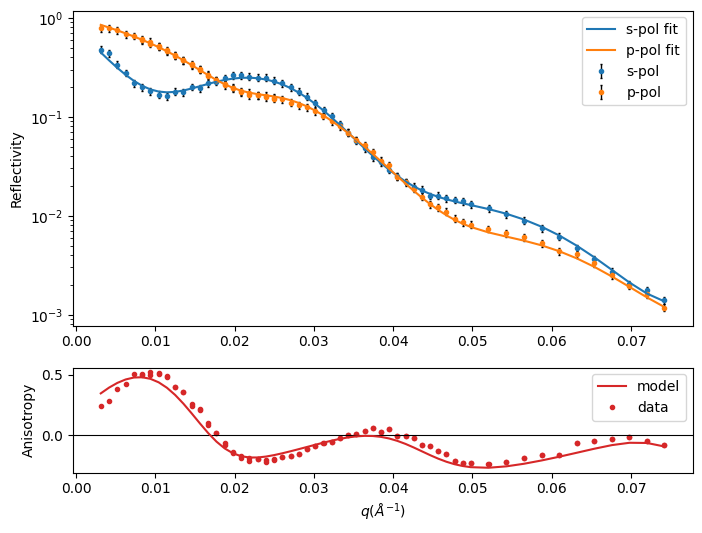

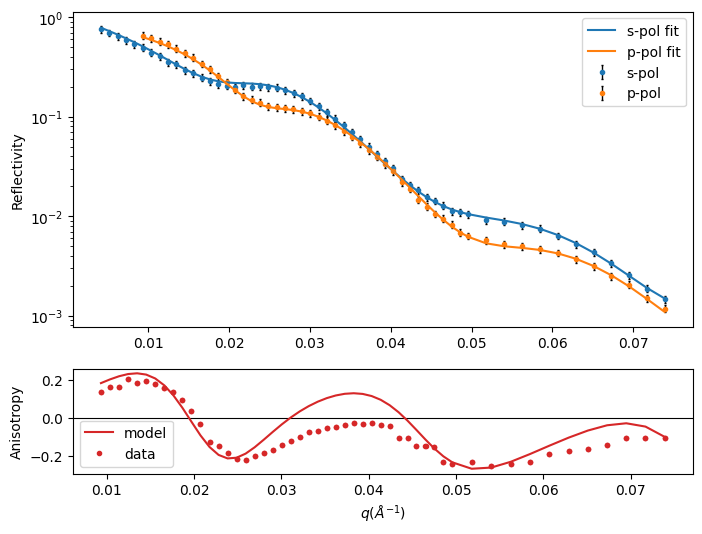

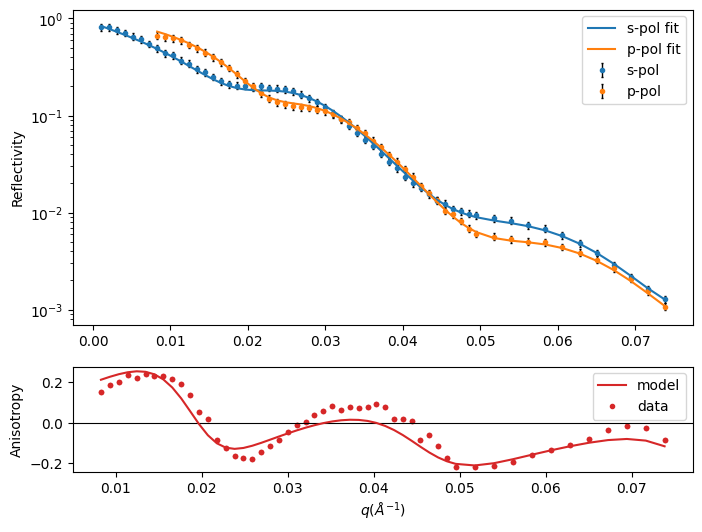

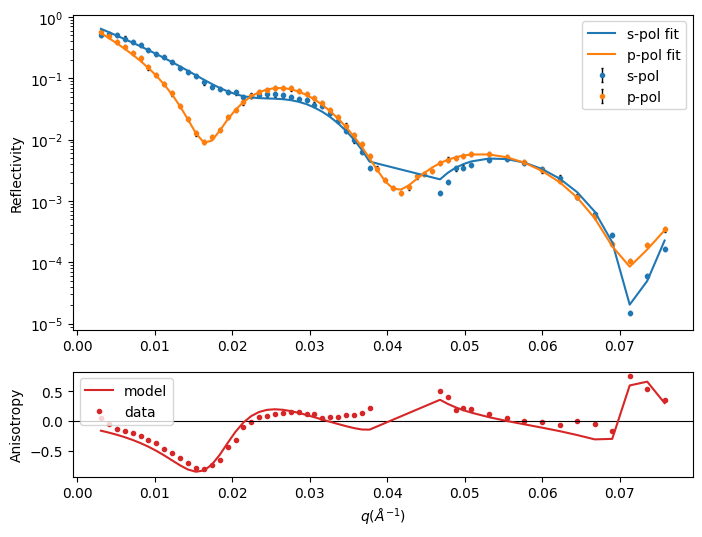

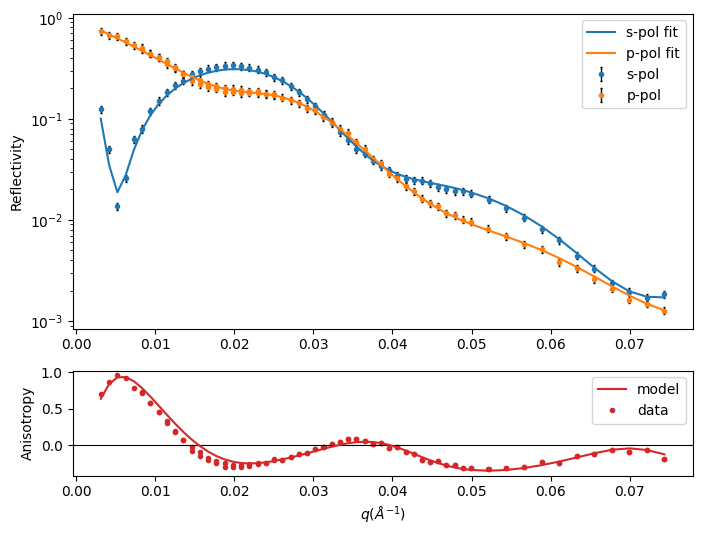

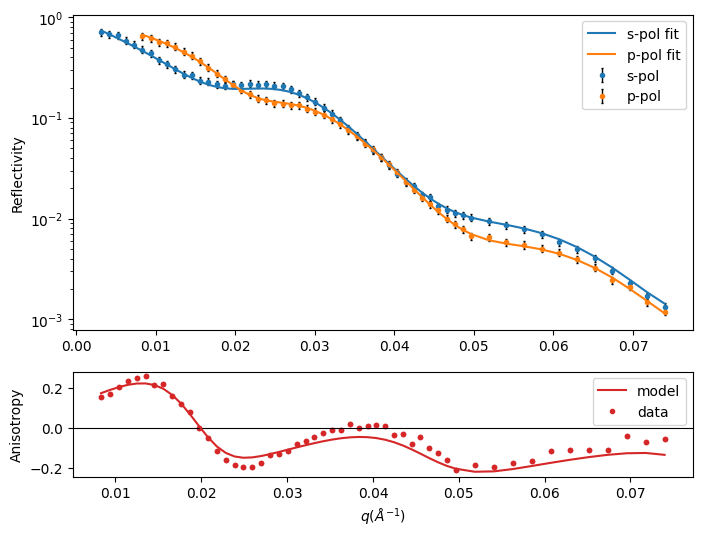

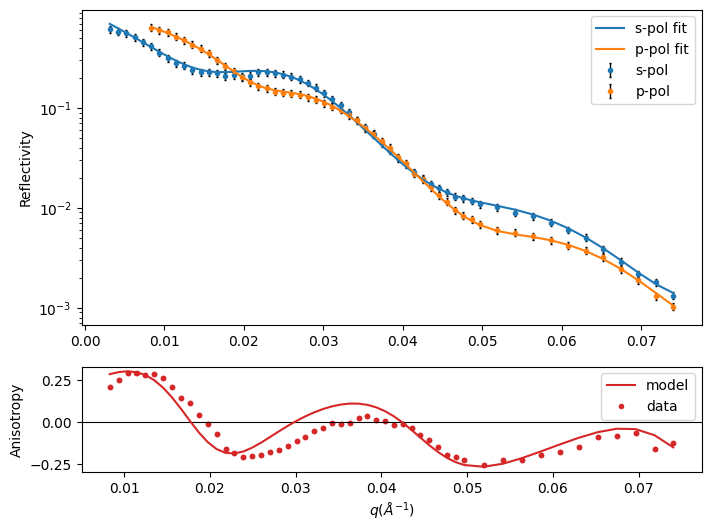

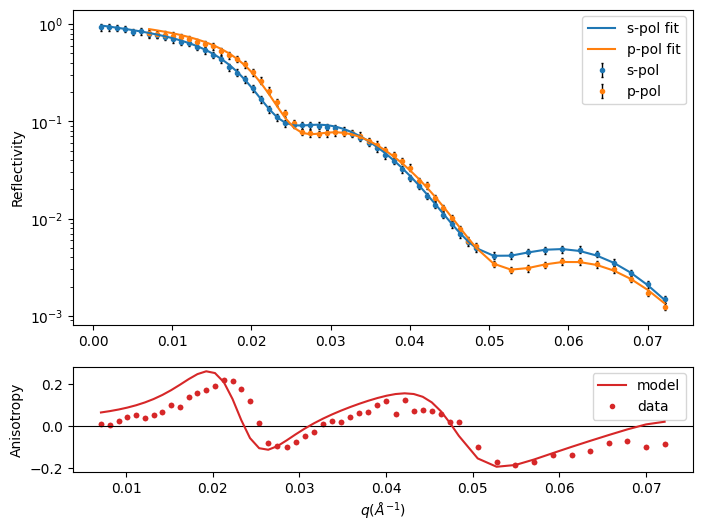

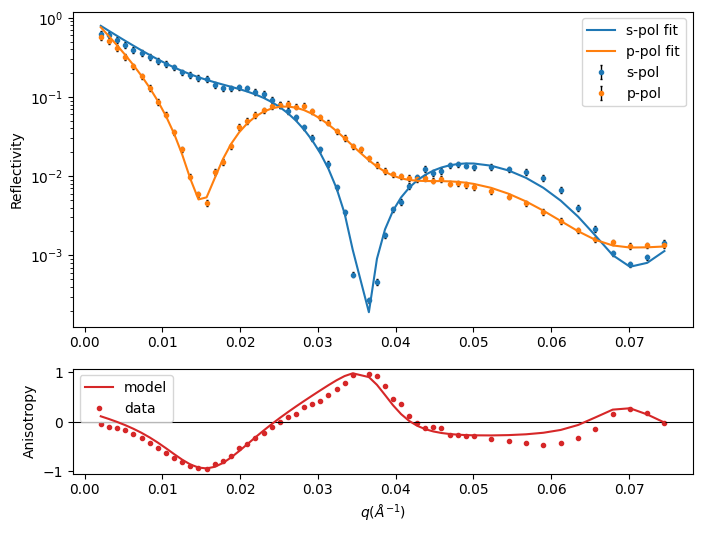

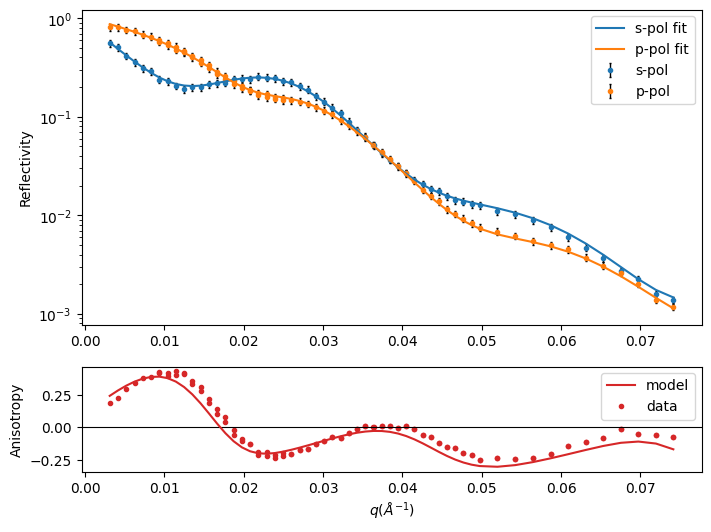

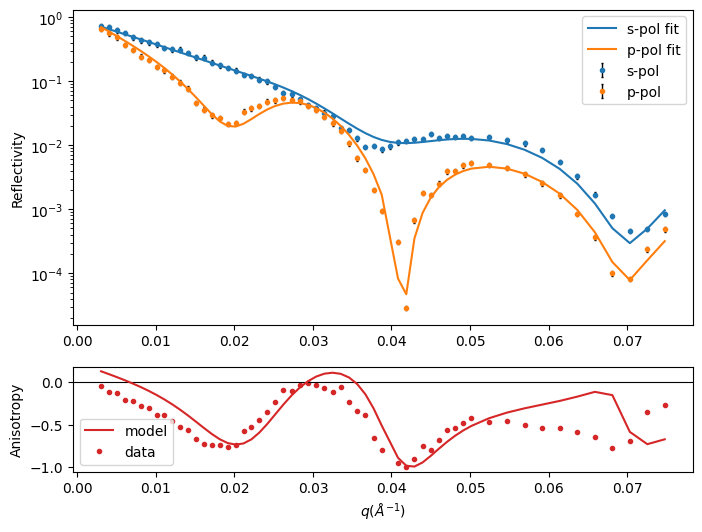

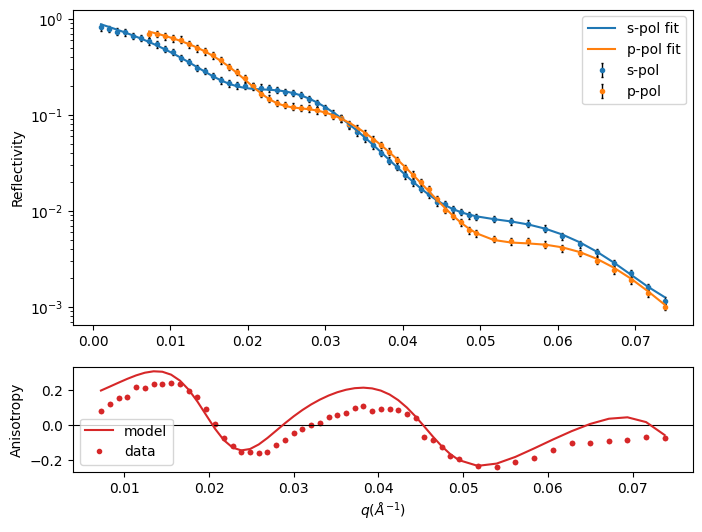

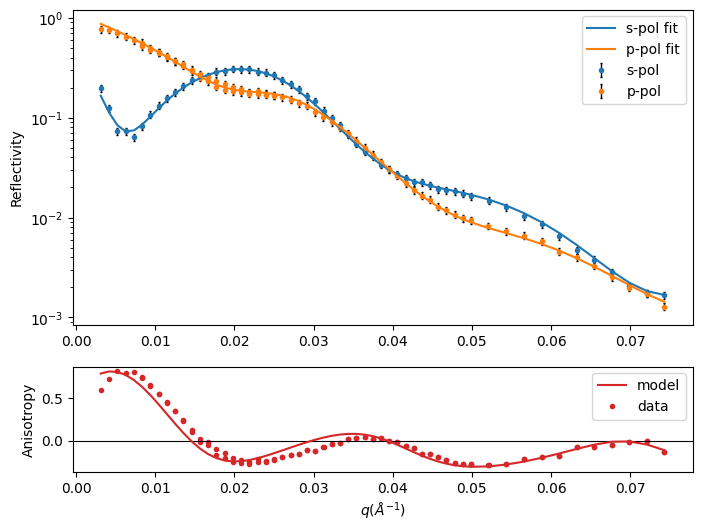

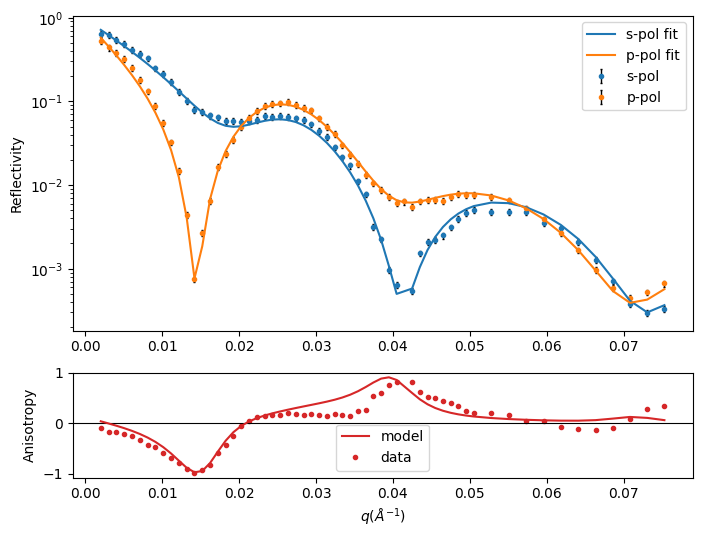

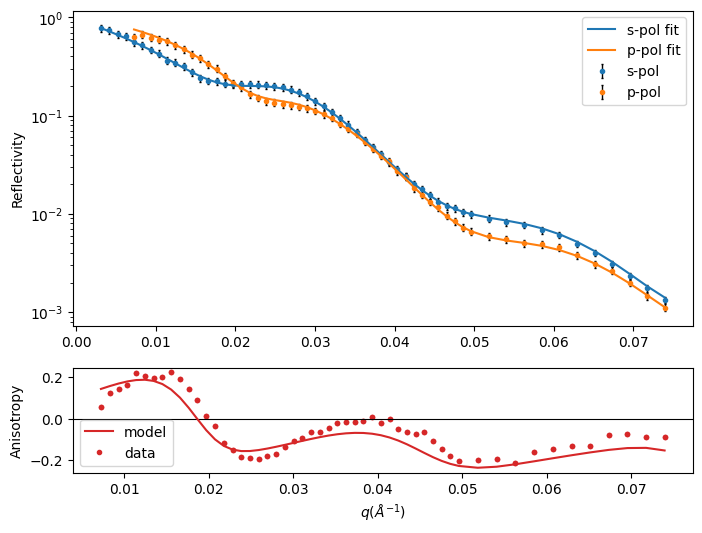

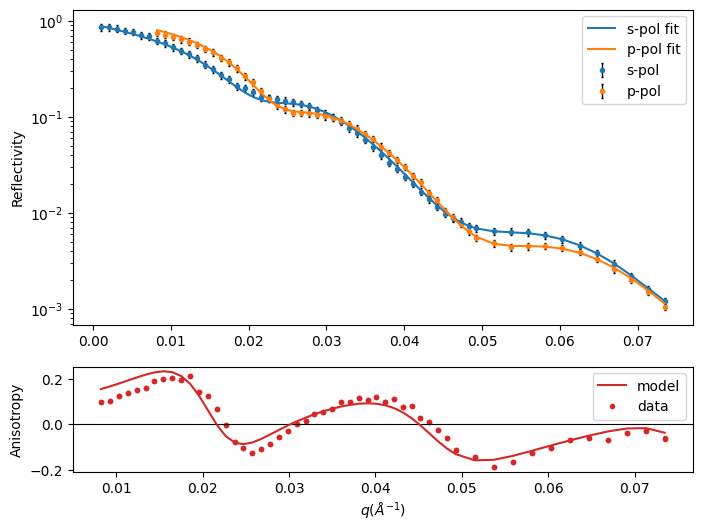

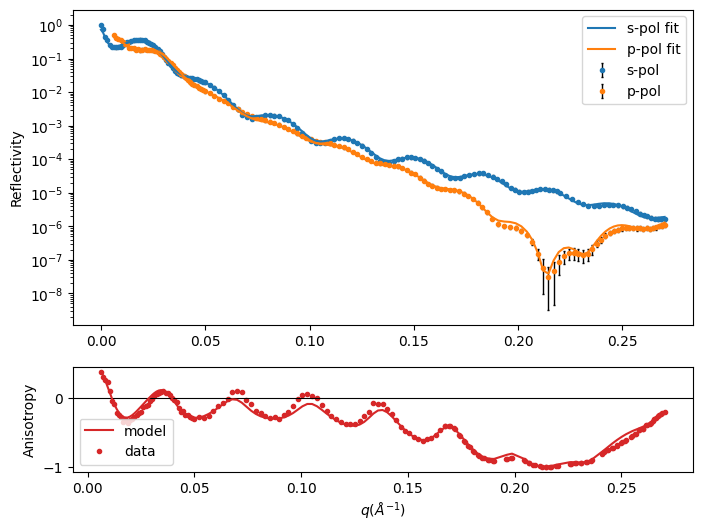

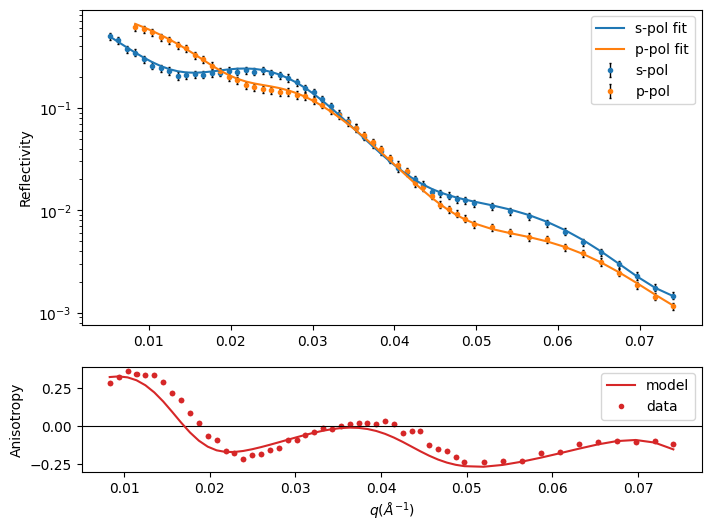

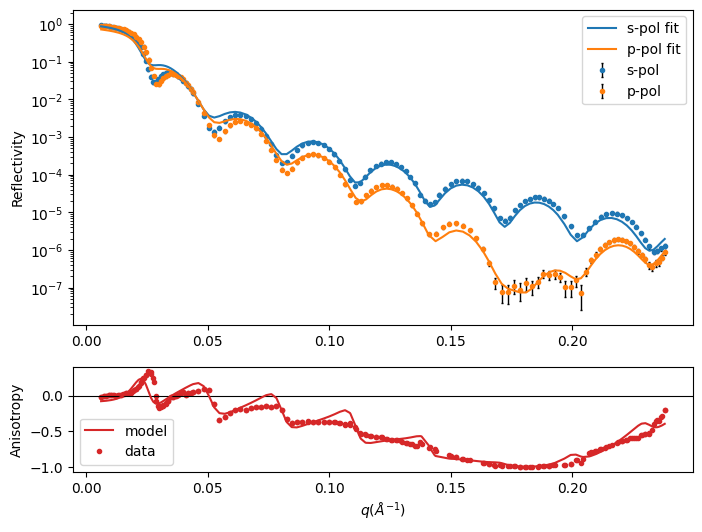

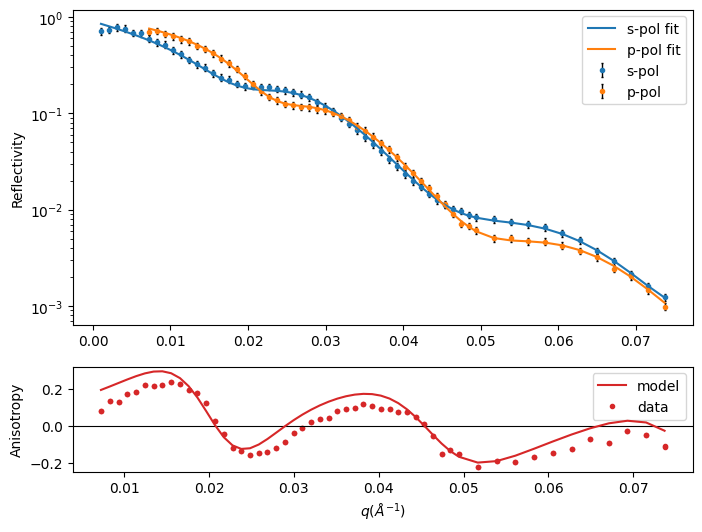

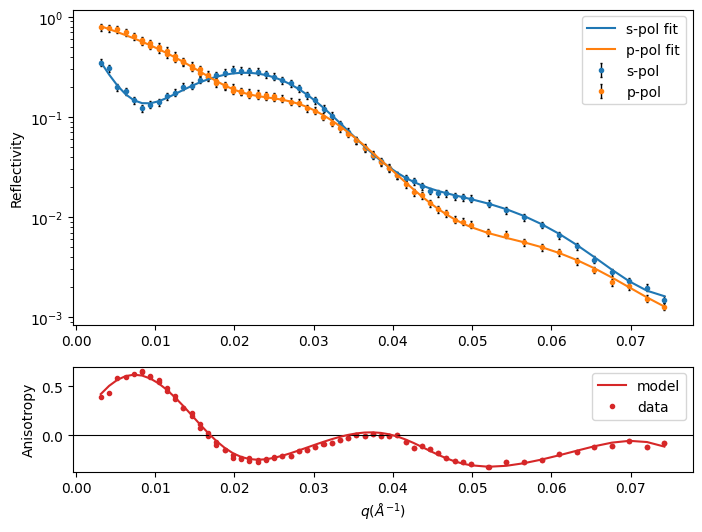

In [26]:
fit_objs = []

for o, e in zip(objectives, energy):
    print(f"Energy: {e} eV")
    if o.model.energy == 250.0:
        # We need to use a MaterialSLD for the surface and Substrate layers
    o = copy.deepcopy(o)
    fitter = fit.CurveFitter(o)
    fitter.fit(
        target="nlpost",
        method="differential_evolution",
        workers=CPU_COUNT,
        updating="deferred",
    )
    fit_objs.append(o)
    o.plot()

In [ ]:
obj_250 = fit_objs[-3]
print(obj_250.parameters)

________________________________________________________________________________
Parameters:  'Model 250.0' 
________________________________________________________________________________
Parameters: 'instrument parameters'
<Parameter:   'scale_s'   , value=0.79422 +/- 0.0115, bounds=[0.6, 1.4]>
<Parameter:   'scale_p'   , value=0.983192 +/- 0.0143, bounds=[0.6, 1.4]>
<Parameter:     'bkg'     , value=7.14339e-08  (fixed) , bounds=[-inf, inf]>
<Parameter:'dq - resolution', value=0  (fixed) , bounds=[-inf, inf]>
<Parameter:  'q_offset'   , value=0  (fixed) , bounds=[-inf, inf]>
<Parameter:'energy_offset', value=0          , bounds=[-1.0, 1.0], constraint=<Parameter:'energy_offset', value=0  (fixed) , bounds=[-0.3, 0.3]>>
<Parameter:'theta_offset_s', value=0.327656 +/- 0.0294, bounds=[-0.5, 0.5]>
<Parameter:'theta_offset_p', value=0.0146224 +/- 0.0278, bounds=[-0.5, 0.5]>
________________________________________________________________________________
Parameters: 'Structure - Monolayer

In [ ]:
fitting_results_free = fit.GlobalObjective(fit_objs)

In [ ]:
chisrd_dft = reduced_chi2(fitting_results)
bic_dft = bic(fitting_results)
aic_dft = aic(fitting_results)
chisrd_free = reduced_chi2(fitting_results_free)
bic_free = bic(fitting_results_free)
aic_free = aic(fitting_results_free)
bayes_factor = np.exp((bic_dft - bic_free) / 2)
akaike_weight = np.exp((aic_dft - aic_free) / 2)
print(f"Reduced Chi2 DFT: {chisrd_dft}, Reduced Chi2 Free: {chisrd_free}")
print(f"BIC DFT: {bic_dft}, BIC Free: {bic_free},  BIC abs diff: {bic_free - bic_dft}")
print(f"AIC DFT: {aic_dft}, AIC Free: {aic_free},  AIC abs diff: {aic_free - aic_dft}")
print(f"Bayes Factor: {bayes_factor}, Akaike Weight: {akaike_weight}")

Reduced Chi2 DFT: 7.493068928578301, Reduced Chi2 Free: 2.7064789836528287
BIC DFT: 824.2585933370649, BIC Free: 2537.0793587833346,  BIC abs diff: 1712.8207654462697
AIC DFT: 225.81768460236995, AIC Free: 599.5528522858566,  AIC abs diff: 373.7351676834867
Bayes Factor: 0.0, Akaike Weight: 6.989393486698297e-82


In [ ]:
with open("fitting_results_free_model.pkl", "wb") as f:
    pickle.dump(fitting_results_free, f)

/home/hduva/projects/xrr_notebooks/.venv/lib/python3.12/site-packages/pyref/fitting/fitters.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(


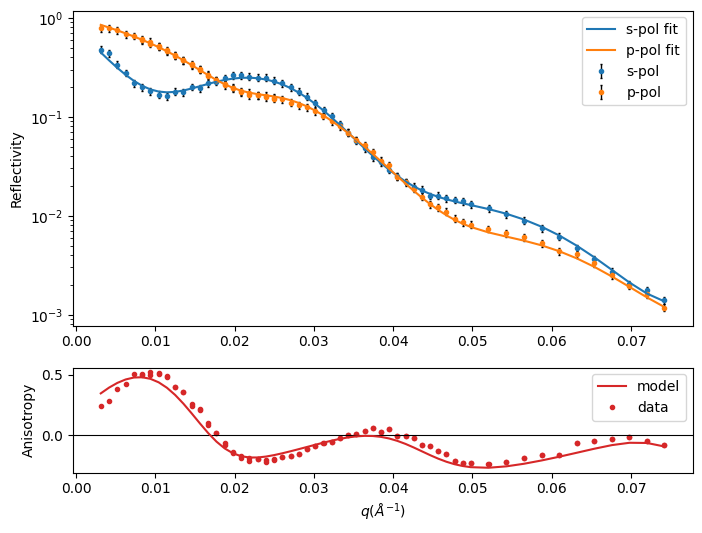

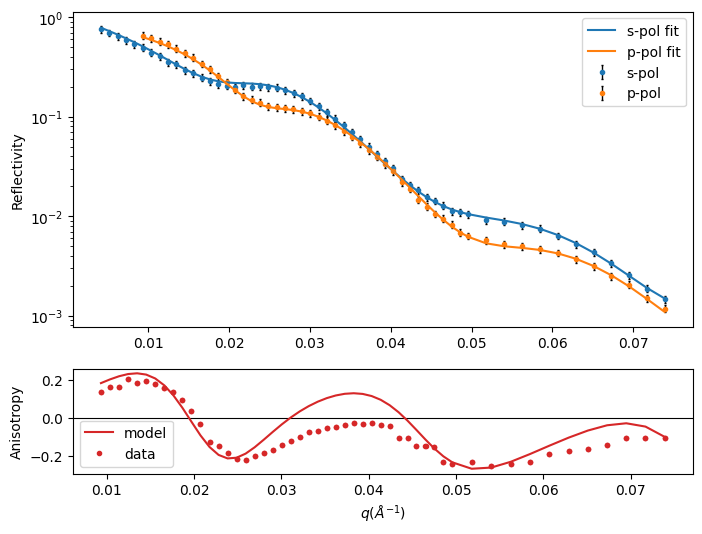

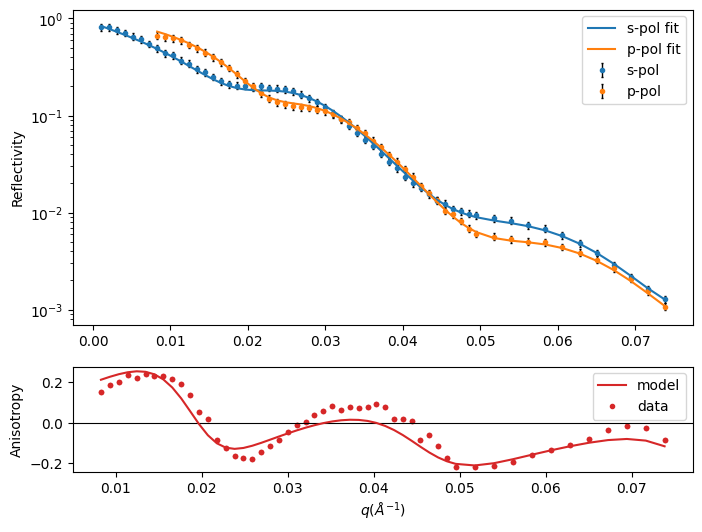

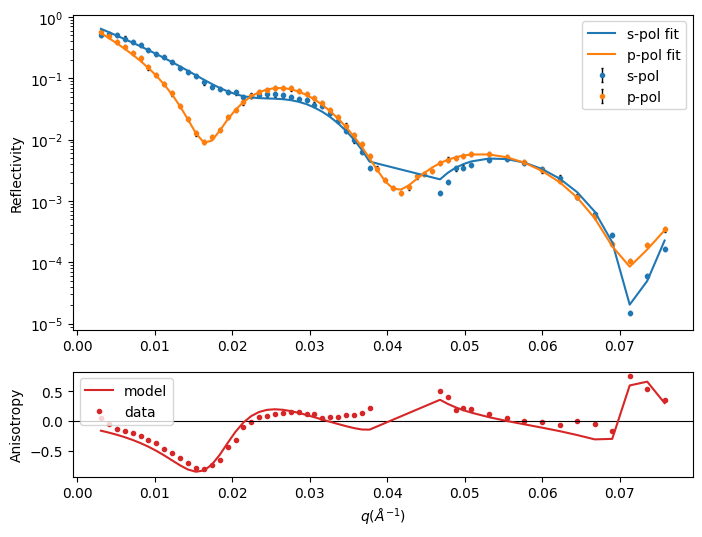

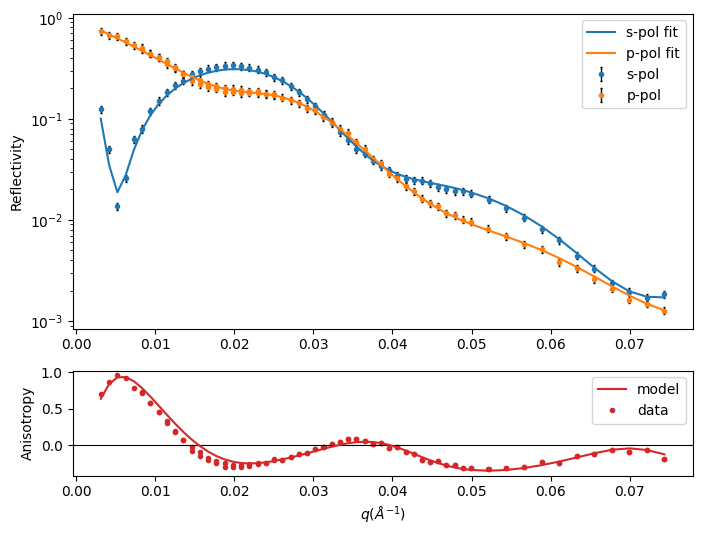

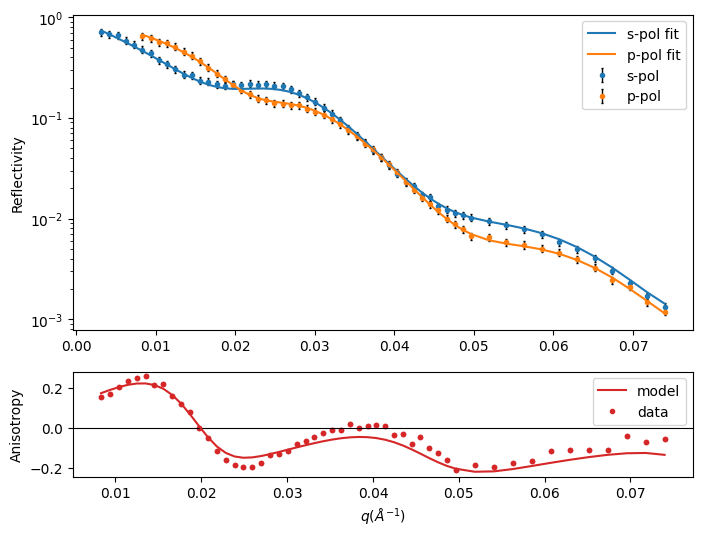

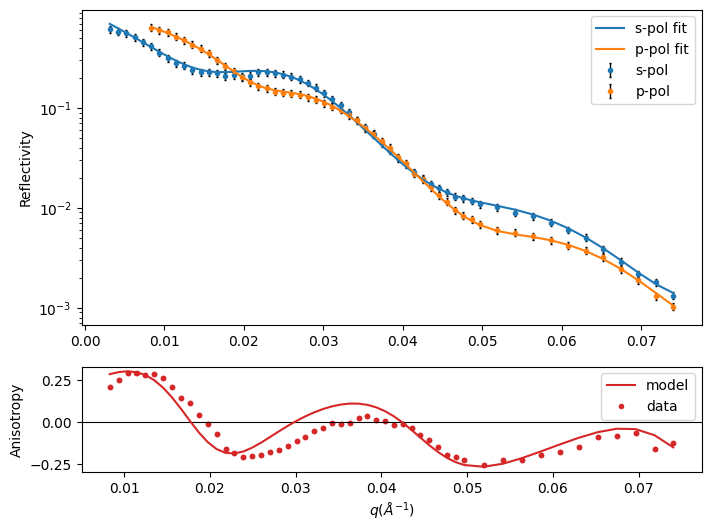

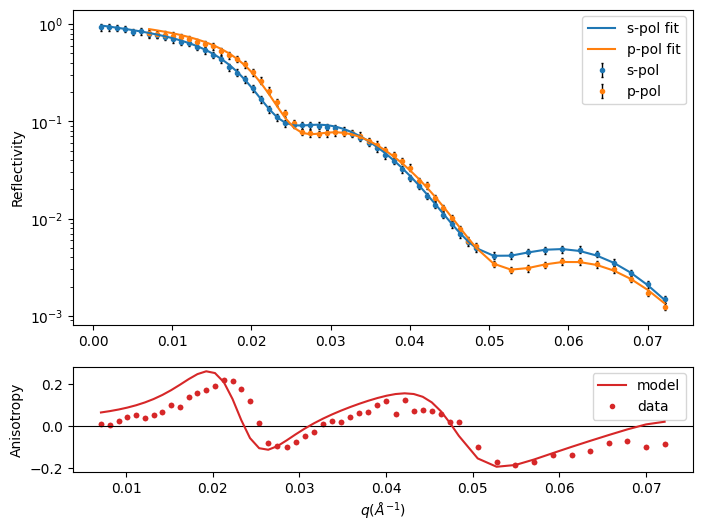

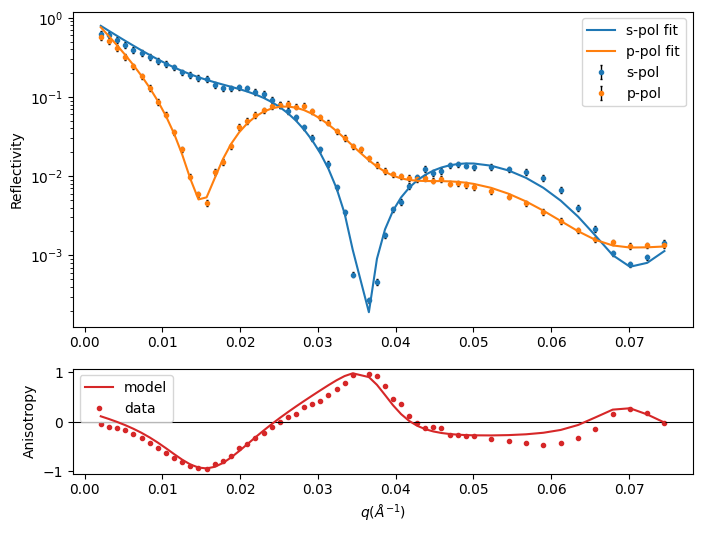

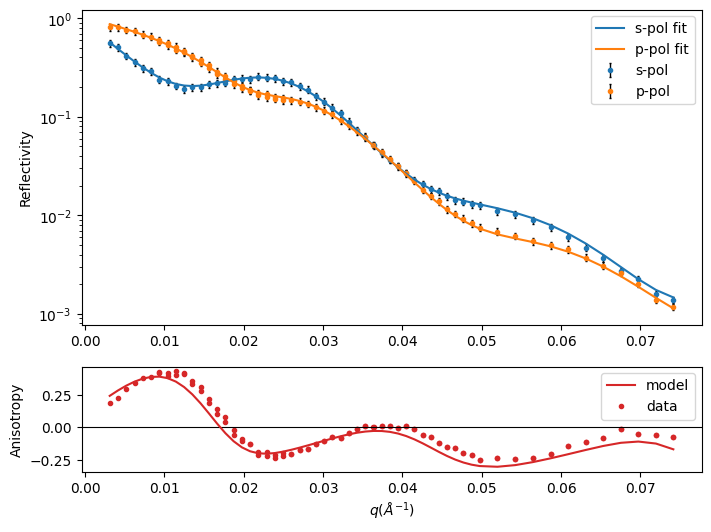

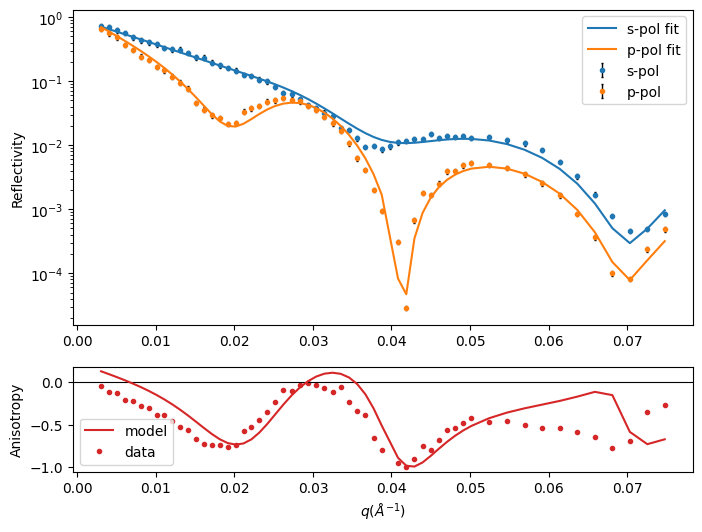

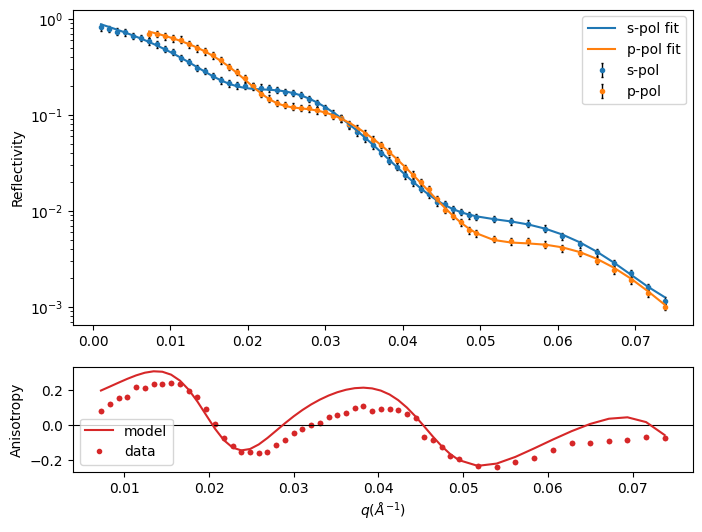

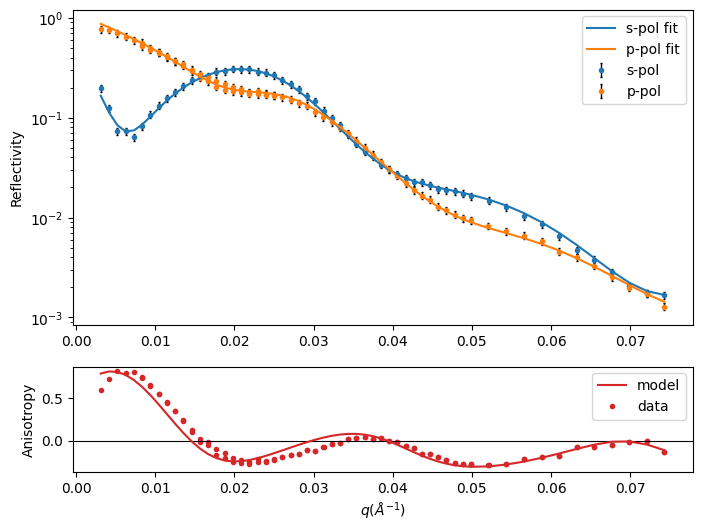

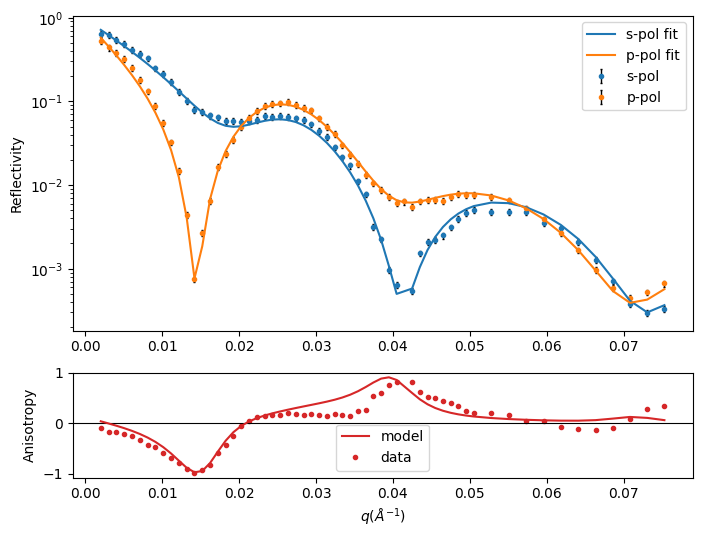

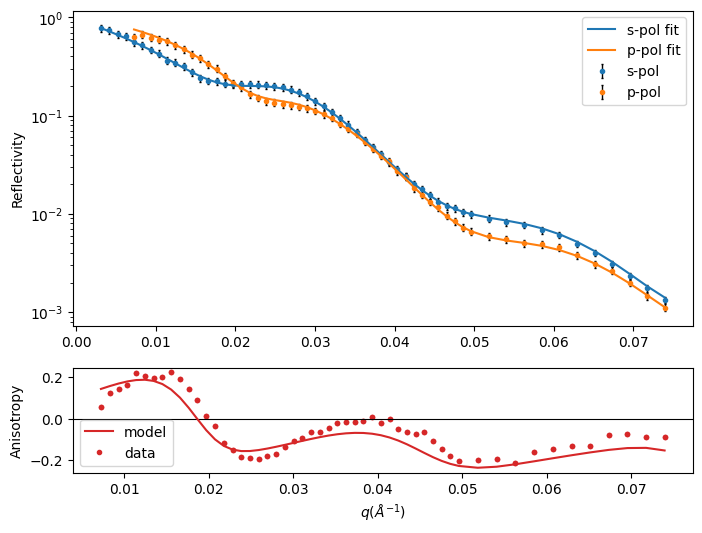

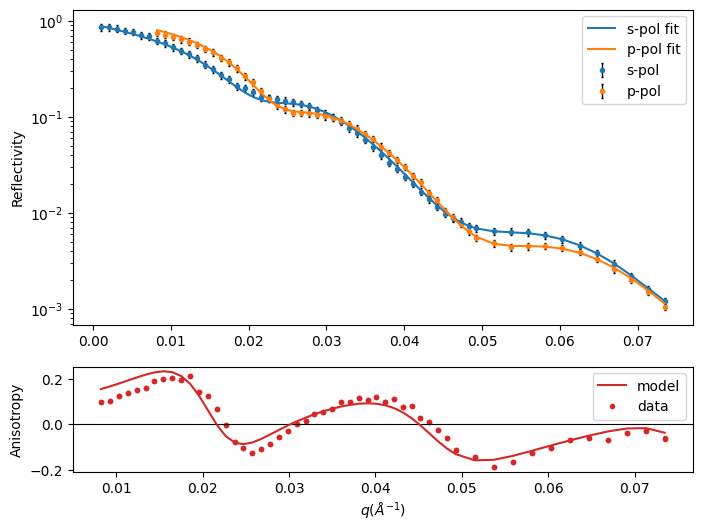

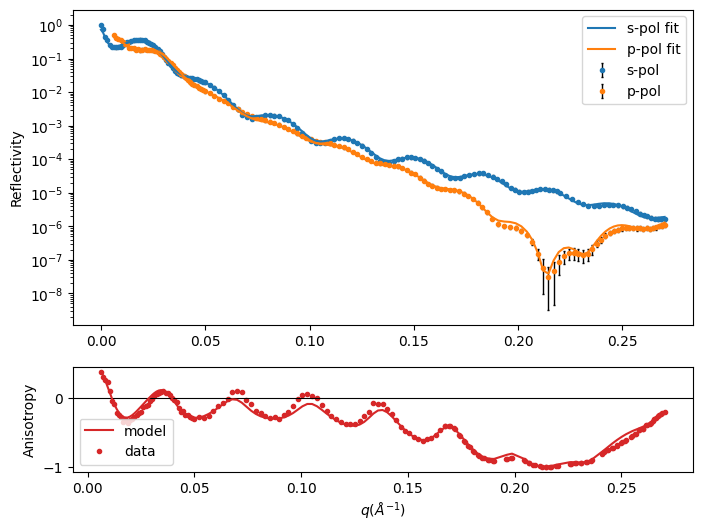

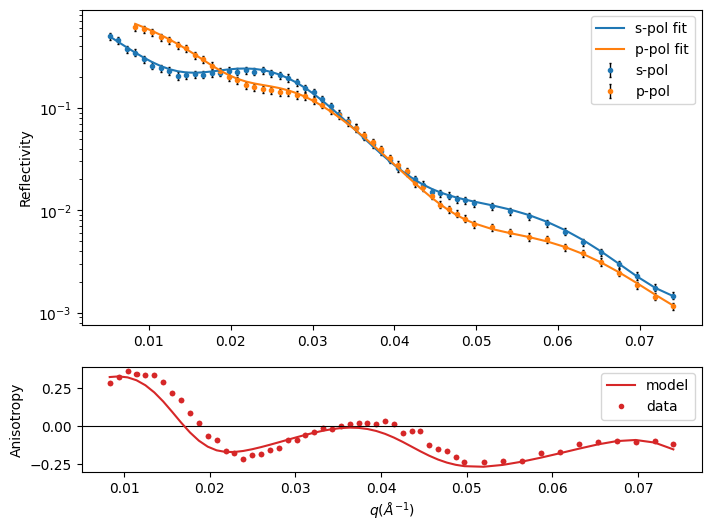

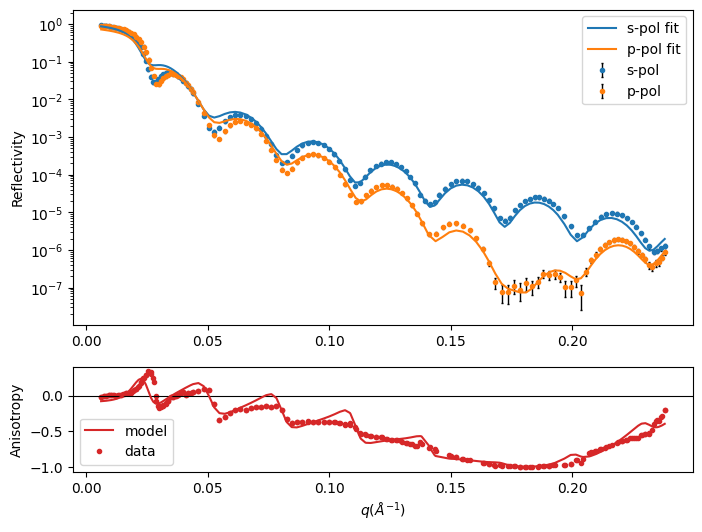

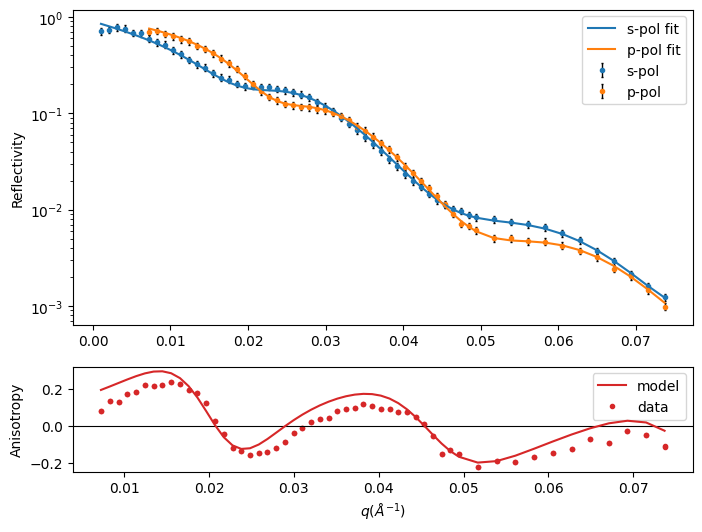

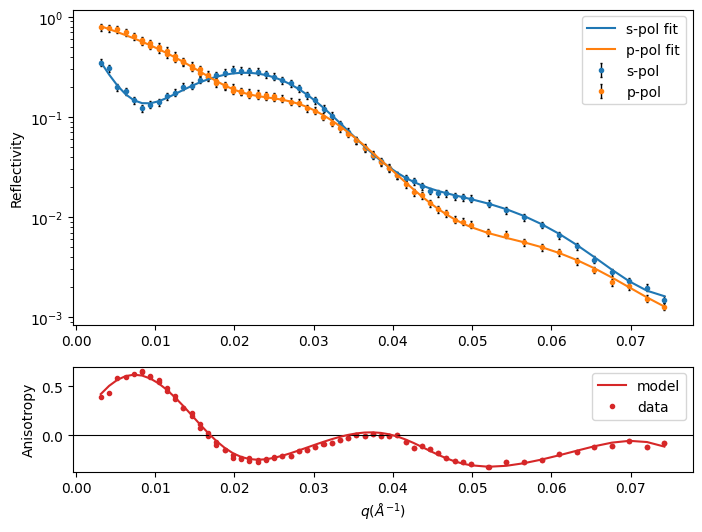

In [ ]:
for o in fitting_results_free.objectives:
    o.plot()

In [ ]:
chisrd_dft = reduced_chi2(fitting_results)
bic_dft = bic(fitting_results)
aic_dft = aic(fitting_results)
chisrd_free = reduced_chi2(fitting_results_free)
bic_free = bic(fitting_results_free)
aic_free = aic(fitting_results_free)
bayes_factor = np.exp((bic_dft - bic_free) / 2)
akaike_weight = np.exp((aic_dft - aic_free) / 2)
print(f"Reduced Chi2 DFT: {chisrd_dft}, Reduced Chi2 Free: {chisrd_free}")
print(
    f"BIC DFT: {bic_dft}, BIC Free: {bic_free}, BIC relative diff: {(bic_free - bic_dft) / abs(bic_dft):.2f}, BIC abs diff: {bic_free - bic_dft}"
)
print(
    f"AIC DFT: {aic_dft}, AIC Free: {aic_free}, AIC relative diff: {(aic_free - aic_dft) / abs(aic_dft):.2f}, AIC abs diff: {aic_free - aic_dft}"
)
print(f"Bayes Factor: {bayes_factor}, Akaike Weight: {akaike_weight}")

Reduced Chi2 DFT: 61.720853364178616, Reduced Chi2 Free: 38.56278614225472
BIC DFT: 1273.390532322746, BIC Free: 3168.7874716974593, BIC relative diff: 1.49, BIC abs diff: 1895.3969393747134
AIC DFT: 674.949623588051, AIC Free: 1231.2609651999817, AIC relative diff: 0.82, AIC abs diff: 556.3113416119306
Bayes Factor: 0.0, Akaike Weight: 1.5795270176641936e-121


In [ ]:
AIC_s = aic(fitting_results)
AIC_c = aic(fitting_results_free)
BIC_s = bic(fitting_results)
BIC_c = bic(fitting_results_free)

ΔAIC = AIC_c - AIC_s
ΔBIC = BIC_c - BIC_s

# Akaike (two‑model case)
w_complex = np.exp(-ΔAIC / 2) / (1 + np.exp(-ΔAIC / 2))

# Approximate Bayes factor (simple vs complex)
BF = np.exp(ΔBIC / 2)

print(f"ΔAIC = {ΔAIC:.2f}, Akaike weight (complex) = {w_complex:.2e}")
print(f"ΔBIC = {ΔBIC:.2f}, Bayes factor (simple/complex) ≈ 10^{np.log10(BF):.1f}")

ΔAIC = 556.31, Akaike weight (complex) = 1.58e-121
ΔBIC = 1895.40, Bayes factor (simple/complex) ≈ 10^inf


/tmp/ipykernel_1667171/533085753.py:13: RuntimeWarning: overflow encountered in exp
  BF = np.exp(ΔBIC / 2)


In [ ]:
ΔBIC / 2

np.float64(947.6984696873567)

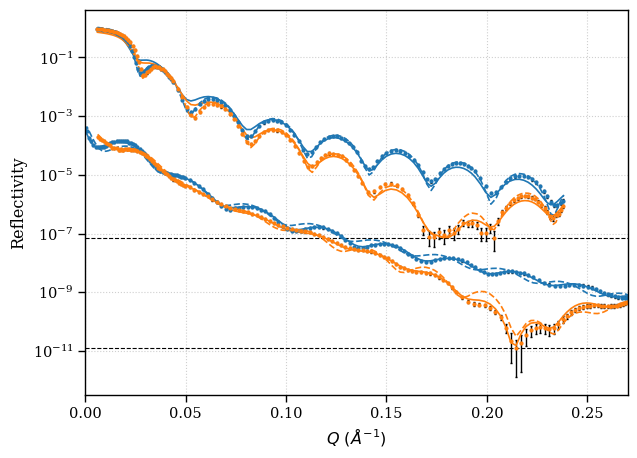

In [ ]:
import seaborn as sns

long_q_energy = [250.0, 283.7]
pre_range = energy[: energy.index(283.7) + 1]
post_range = energy[energy.index(283.7) :]
#  Plot the data sets with 4 pannels, left long q, left mid pre_range, right mid
#  post_range, right blank
fit_dft = [fitting_results.objectives[0], fitting_results.objectives[-5]]
sns.set_context("paper", font_scale=1.2)  # PRL‑ready font size
palette = {
    "refined": "blue",
    "raw": "gray",
}  # light gray

fig, axes = plt.subplots(
    ncols=1,
    figsize=(7, 5),
)
axes.set_xlim(0, 0.27)
for i, e in enumerate(long_q_energy):
    o = fit_objs[energy.index(e)]
    o_dft = fit_dft[i]
    data = loaded_data[str(e)]
    scale_factor = 50 ** (-2 * i)
    axes.errorbar(
        x=data.s.x,
        y=data.s.y * scale_factor,
        yerr=data.s.y_err * scale_factor,
        marker="o",
        ms=2,
        lw=0,
        elinewidth=1,
        capsize=1,
        ecolor="k",
        label=f"{e} eV s-pol",
        color="C0",
        alpha=1,
    )
    axes.errorbar(
        x=data.p.x,
        y=data.p.y * scale_factor,
        yerr=data.p.y_err * scale_factor,
        marker="o",
        ms=2,
        lw=0,
        elinewidth=1,
        capsize=1,
        ecolor="k",
        label=f"{e} eV p-pol",
        color="C1",
        alpha=1,
    )
    bkg = data.p.y.min()
    axes.axhline(bkg * scale_factor, color="k", ls="--", lw=0.8)
    #  Plot the fits
    o.model.bkg = bkg
    o.model.pol = "s"
    ss = o.model(data.s.x)
    axes.plot(data.s.x, ss * scale_factor, label=f"{e} eV s-pol fit", c="C0")
    # Plot the DFT fit for comparison
    o_dft.model.bkg = bkg
    o_dft.model.pol = "s"
    ss_dft = o_dft.model(data.s.x)
    axes.plot(
        data.s.x, ss_dft * scale_factor, label=f"{e} eV s-pol DFT fit", c="C0", ls="--"
    )
    o.model.pol = "p"
    pp = o.model(data.p.x)
    axes.plot(data.p.x, pp * scale_factor, label=f"{e} eV p-pol fit", c="C1")
    # Plot the DFT fit for comparison
    o_dft.model.pol = "p"
    pp_dft = o_dft.model(data.p.x)
    axes.plot(
        data.p.x, pp_dft * scale_factor, label=f"{e} eV p-pol DFT fit", c="C1", ls="--"
    )
    axes.set_yscale("log")
    axes.set_ylabel("Reflectivity")
    axes.set_xlabel(r"$Q\ (\AA^{-1})$")
    # reset to sp
    o.model.pol = "sp"
    o_dft.model.pol = "sp"

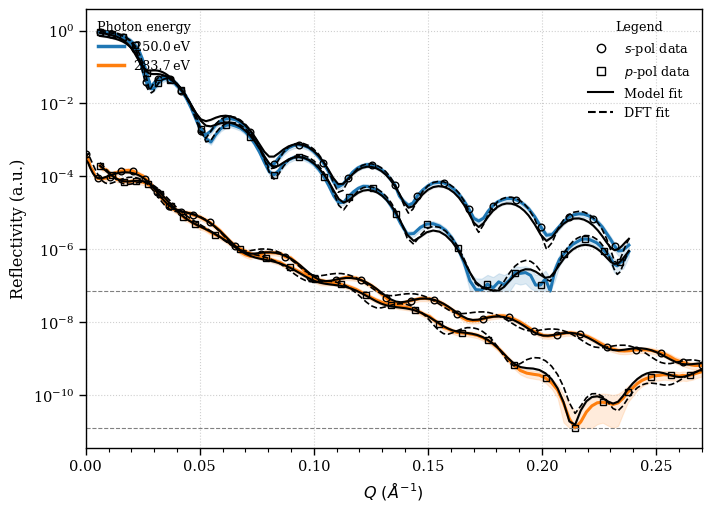

In [ ]:
# --------------------------------------------------------------
# 0️⃣  Imports & global style
# --------------------------------------------------------------
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

mpl.rcParams.update(
    {
        "font.size": 11,
        "font.family": "serif",
        "text.usetex": False,
        "axes.grid": True,
        "grid.linestyle": ":",
        "grid.alpha": 0.6,
        "legend.frameon": False,
    }
)

# --------------------------------------------------------------
# 1️⃣  Input data (replace with your real objects)
# --------------------------------------------------------------
# Example: you said you have only two energies
long_q_energy = [250.0, 283.7]  # <-- change as needed
energies = np.array(long_q_energy)

# Dummy containers – replace with your real ones
#   fit_objs  : list of fit objects (experimental)
#   fit_dft   : list of fit objects (DFT)
#   loaded_data : dict keyed by str(energy) with .s and .p fields
#   energy    : list of all energies (used to locate the index)
# For the purpose of this snippet we assume they already exist.
# --------------------------------------------------------------

# --------------------------------------------------------------
# 2️⃣  Colour handling – two distinct colours
# --------------------------------------------------------------
cols = ["C0", "C1"]  # colour‑blind safe (tab10/C0‑C1)

# --------------------------------------------------------------
# 3️⃣  Figure / Axes
# --------------------------------------------------------------
fig, ax = plt.subplots(figsize=(7, 5), constrained_layout=True)

# --------------------------------------------------------------
# 4️⃣  Loop over the two energies: data + model + DFT
# --------------------------------------------------------------
for i, (E, col) in enumerate(zip(energies, cols)):
    # ----- objects for this energy ---------------------------------
    o = fit_objs[energy.index(E)]  # experimental fit object
    o_dft = fit_dft[i]  # DFT fit object
    data = loaded_data[str(E)]  # contains .s and .p (x, y, y_err)
    scale = 50 ** (-2 * i)  # vertical offset factor
    bkg = data.p.y.min()

    # ----- helper: safe lower bound for log‑scale -----------------
    def _clip_low(arr):
        # guarantee positivity (log cannot handle ≤0)
        return np.clip(arr, 1e-12, None)

    # ----- 1️⃣  Data points + ±2σ shading -------------------------
    # s‑pol (circles)
    ax.fill_between(
        data.s.x,
        _clip_low((data.s.y - 2 * data.s.y_err) * scale),
        (data.s.y + 2 * data.s.y_err) * scale,
        color=col,
        alpha=0.15,
        label="_nolegend_",
    )
    #  plot every 10th point to reduce overplotting
    ax.plot(
        data.s.x,
        data.s.y * scale,
        color=col,
        lw=2.2,
        marker="o",
        markevery=5,
        markerfacecolor="none",
        markeredgecolor="k",
        label="_nolegend_",
    )

    # p‑pol (squares)
    ax.fill_between(
        data.p.x,
        _clip_low(np.maximum(data.p.y - 2 * data.p.y_err, bkg) * scale),
        (data.p.y + 2 * data.p.y_err) * scale,
        color=col,
        alpha=0.15,
        label="_nolegend_",
    )
    ax.plot(
        data.p.x,
        data.p.y * scale,
        color=col,
        lw=2.2,
        marker="s",
        markevery=5,
        markerfacecolor="none",
        markeredgecolor="k",
        label="_nolegend_",
    )

    # ----- background reference line (same for both polarisations) --
    ax.axhline(bkg * scale, color="gray", ls="--", lw=0.8)

    # ----- 2️⃣  Model fits (solid) and DFT fits (dashed) ----------
    # ---- s‑pol ---------------------------------------------------
    o.model.bkg = bkg
    o.model.pol = "s"
    ss = o.model(data.s.x)

    o_dft.model.bkg = bkg
    o_dft.model.pol = "s"
    ss_dft = o_dft.model(data.s.x)

    # ----- Plot the curves -----------------------------------------
    ax.plot(data.s.x, ss * scale, color="k", lw=1.5, label="_nolegend_", zorder=10)
    ax.plot(
        data.s.x,
        ss_dft * scale,
        color="k",
        lw=1.2,
        ls="--",
        label="_nolegend_",
        zorder=10,
    )

    # ----- OPTIONAL: shade model‑uncertainty band ------------------
    # Choose ONE of the two options below (comment out the other).

    # Option A – a *fixed* relative error band (e.g. 5 % of the model)
    rel_err = 0.05  # 5 %
    ax.fill_between(
        data.s.x,
        _clip_low((ss * (1 - rel_err)) * scale),
        (ss * (1 + rel_err)) * scale,
        color="k",
        alpha=0.07,
        zorder=5,
    )

    # Option B – shade the *difference* between experimental model and DFT
    # ax.fill_between(data.s.x,
    #                 np.minimum(ss, ss_dft) * scale,
    #                 np.maximum(ss, ss_dft) * scale,
    #                 color=col, alpha=0.12, zorder=5)

    # ---- p‑pol ---------------------------------------------------
    o.model.pol = "p"
    pp = o.model(data.p.x)

    o_dft.model.pol = "p"
    pp_dft = o_dft.model(data.p.x)

    ax.plot(data.p.x, pp * scale, color="k", lw=1.5, label="_nolegend_", zorder=10)
    ax.plot(
        data.p.x,
        pp_dft * scale,
        color="k",
        lw=1.2,
        ls="--",
        label="_nolegend_",
        zorder=10,
    )

    # Optional: same error‑band idea for p‑pol (repeat if you want)
    ax.fill_between(
        data.p.x,
        _clip_low((pp * (1 - rel_err)) * scale),
        (pp * (1 + rel_err)) * scale,
        color="k",
        alpha=0.07,
        zorder=5,
    )

    # Reset polarity – safety only
    o.model.pol = "sp"
    o_dft.model.pol = "sp"

# --------------------------------------------------------------
# 5️⃣  Global axis settings
# --------------------------------------------------------------
ax.set_xlim(0, 0.27)
ax.set_yscale("log")
ax.set_xlabel(r"$Q\ (\AA^{-1})$")
ax.set_ylabel(r"Reflectivity (a.u.)")
ax.minorticks_on()

# --------------------------------------------------------------
# 6️⃣  Legend #1 – markers & line‑styles (same as Fig‑1)
# --------------------------------------------------------------
style_legend = [
    Line2D(
        [0],
        [0],
        marker="o",
        color="k",
        markerfacecolor="none",
        markersize=6,
        linestyle="None",
        label=r"$s$‑pol data",
    ),
    Line2D(
        [0],
        [0],
        marker="s",
        color="k",
        markerfacecolor="none",
        markersize=6,
        linestyle="None",
        label=r"$p$‑pol data",
    ),
    Line2D([0], [0], color="k", lw=1.5, linestyle="-", label=r"Model fit"),
    Line2D([0], [0], color="k", lw=1.5, linestyle="--", label=r"DFT fit"),
]
leg1 = ax.legend(
    handles=style_legend,
    loc="upper right",
    title="Legend",
    fontsize="small",
    title_fontsize="small",
    ncol=1,
)
ax.add_artist(leg1)  # keep this legend while we add the second one

# --------------------------------------------------------------
# 7️⃣  Legend #2 – energy colour coding (two entries)
# --------------------------------------------------------------
energy_handles = [Line2D([0], [0], color=c, lw=2.5) for c in cols]
energy_labels = [f"{E:.1f} eV" for E in energies]

ax.legend(
    handles=energy_handles,
    labels=energy_labels,
    title="Photon energy",
    loc="upper left",
    fontsize="small",
    title_fontsize="small",
    ncol=1,
)

# --------------------------------------------------------------
# 8️⃣  Save / Show
# --------------------------------------------------------------
fig.savefig("fit_comparison_two_energies.png", transparent=True)
plt.show()

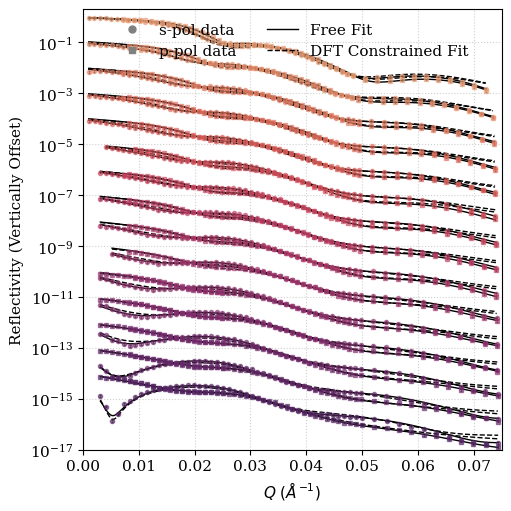

In [ ]:
# Create a subplot for the mid-range energies
fig, ax = plt.subplots(figsize=(5, 5), constrained_layout=True)

# Define the energy range to plot (between 250 and 283.7 eV)
mid_range_energies = [e for e in energy if 250.0 < e < 283.7]
mid_range_energies.sort()

# Define a color palette
palette = sns.color_palette("flare", n_colors=len(mid_range_energies))

# Loop over the selected energies to plot the data and fits
for i, e in enumerate(mid_range_energies):
    # Get the corresponding objects for the current energy
    energy_idx = energy.index(e)
    obj_free = fit_objs[energy_idx]
    obj_dft = fitting_results.objectives[i + 1]
    data = loaded_data[str(e)]

    # Apply a scaling factor for vertical separation
    scale_factor = 10 ** (-i)
    color = palette[i]

    # Plot s-polarization data
    ax.errorbar(
        data.s.x,
        data.s.y * scale_factor,
        yerr=data.s.y_err * scale_factor,
        fmt="o",
        ms=3,
        color=color,
        ecolor="k",
        elinewidth=0.5,
        capsize=1,
        alpha=0.6,
        label=f"{e} eV" if i == 0 else "",
    )

    # Plot p-polarization data (using a different marker)
    ax.errorbar(
        data.p.x,
        data.p.y * scale_factor,
        yerr=data.p.y_err * scale_factor,
        fmt="s",
        ms=3,
        color=color,
        ecolor="k",
        elinewidth=0.5,
        capsize=1,
        alpha=0.6,
    )

    # Plot the free model fit (solid line)
    q_vals = np.linspace(min(data.x), max(data.x), 500)
    obj_free.model.pol = "s"
    obj_free.model.bkg = 0
    s_fit_free = obj_free.model(q_vals)
    obj_free.model.pol = "p"
    p_fit_free = obj_free.model(q_vals)
    ax.plot(q_vals, s_fit_free * scale_factor, color="k", lw=1.0)
    ax.plot(q_vals, p_fit_free * scale_factor, color="k", lw=1.0)

    # Plot the DFT model fit (dashed line)
    obj_dft.model.pol = "s"
    s_fit_dft = obj_dft.model(q_vals)
    obj_dft.model.pol = "p"
    p_fit_dft = obj_dft.model(q_vals)
    ax.plot(q_vals, s_fit_dft * scale_factor, color="k", ls="--", lw=1.0)
    ax.plot(q_vals, p_fit_dft * scale_factor, color="k", ls="--", lw=1.0)

    # Add energy label text
    # ax.text(
    #     0.15,
    #     np.median(data.s.y) * scale_factor,
    #     f"{e:.1f} eV",
    #     fontsize=9,
    #     bbox=dict(facecolor="white", alpha=0.5, edgecolor="none", pad=1),
    # )


# Create custom legend
legend_elements = [
    Line2D(
        [0],
        [0],
        marker="o",
        color="gray",
        label="s-pol data",
        linestyle="None",
        ms=5,
    ),
    Line2D(
        [0],
        [0],
        marker="s",
        color="gray",
        label="p-pol data",
        linestyle="None",
        ms=5,
    ),
    Line2D([0], [0], color="k", lw=1, label="Free Fit"),
    Line2D([0], [0], color="k", lw=1, ls="--", label="DFT Constrained Fit"),
]
ax.legend(handles=legend_elements, loc="upper center", ncols=2)
ax.set_xlim(0, 0.075)
ax.set_ylim(1e-17, 2)
# Finalize plot settings
ax.set_yscale("log")
ax.set_xlabel(r"$Q\ (\AA^{-1})$")
ax.set_ylabel("Reflectivity (Vertically Offset)")
# ax.set_title("Comparison of Fits for Intermediate Energies")
plt.show()

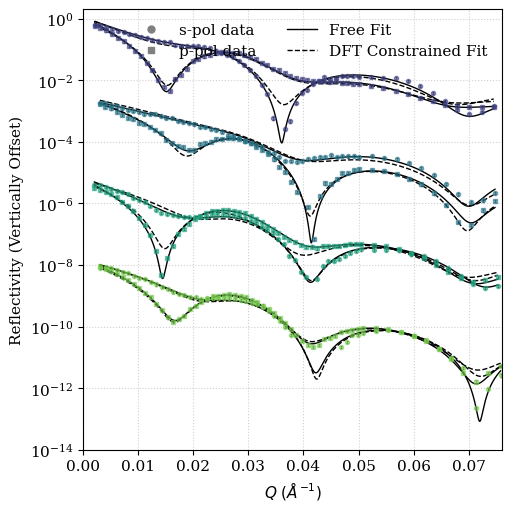

In [ ]:
# Create a subplot for the post-edge energies
fig, ax = plt.subplots(figsize=(5, 5), constrained_layout=True)

# Define the energy range to plot (energies > 283.7 eV)
post_range_energies = [e for e in energy if e > 283.7]
post_range_energies.sort()

# Define a color palette
palette = sns.color_palette("viridis", n_colors=len(post_range_energies))


def get_objective_by_energy(global_obj, energy_val):
    """Helper to find an objective in a GlobalObjective by energy."""
    for o in global_obj.objectives:
        if np.isclose(o.model.energy, energy_val):
            return o
    return None


# Loop over the selected energies to plot the data and fits
for i, e in enumerate(post_range_energies):
    # Get the corresponding objects for the current energy
    energy_idx = energy.index(e)
    obj_free = fit_objs[energy_idx]
    obj_dft = get_objective_by_energy(fitting_results, e)
    data = loaded_data[str(e)]

    # Apply a scaling factor for vertical separation
    scale_factor = 20 ** (-2 * i)
    color = palette[i]

    # Plot s-polarization data
    ax.errorbar(
        data.s.x,
        data.s.y * scale_factor,
        yerr=data.s.y_err * scale_factor,
        fmt="o",
        ms=3,
        color=color,
        ecolor="k",
        elinewidth=0.5,
        capsize=1,
        alpha=0.6,
        label=f"{e} eV" if i == 0 else "",
    )

    # Plot p-polarization data (using a different marker)
    ax.errorbar(
        data.p.x,
        data.p.y * scale_factor,
        yerr=data.p.y_err * scale_factor,
        fmt="s",
        ms=3,
        color=color,
        ecolor="k",
        elinewidth=0.5,
        capsize=1,
        alpha=0.6,
    )

    # Plot the free model fit (solid line)
    q_vals = np.linspace(min(data.x), max(data.x), 500)
    obj_free.model.pol = "s"
    obj_free.model.bkg = 0
    s_fit_free = obj_free.model(q_vals)
    obj_free.model.pol = "p"
    p_fit_free = obj_free.model(q_vals)
    ax.plot(q_vals, s_fit_free * scale_factor, color="k", lw=1.0)
    ax.plot(q_vals, p_fit_free * scale_factor, color="k", lw=1.0)

    # Plot the DFT model fit (dashed line)
    if obj_dft:
        obj_dft.model.pol = "s"
        s_fit_dft = obj_dft.model(q_vals)
        obj_dft.model.pol = "p"
        p_fit_dft = obj_dft.model(q_vals)
        ax.plot(q_vals, s_fit_dft * scale_factor, color="k", ls="--", lw=1.0)
        ax.plot(q_vals, p_fit_dft * scale_factor, color="k", ls="--", lw=1.0)


# Create custom legend (same as the previous cell)
legend_elements = [
    Line2D(
        [0],
        [0],
        marker="o",
        color="gray",
        label="s-pol data",
        linestyle="None",
        ms=5,
    ),
    Line2D(
        [0],
        [0],
        marker="s",
        color="gray",
        label="p-pol data",
        linestyle="None",
        ms=5,
    ),
    Line2D([0], [0], color="k", lw=1, label="Free Fit"),
    Line2D([0], [0], color="k", lw=1, ls="--", label="DFT Constrained Fit"),
]
ax.legend(handles=legend_elements, loc="upper right", ncols=2)
ax.set_xlim(0, 0.076)
ax.set_ylim(1e-14, 2)

# Finalize plot settings
ax.set_yscale("log")
ax.set_xlabel(r"$Q\ (\AA^{-1})$")
ax.set_ylabel("Reflectivity (Vertically Offset)")
plt.show()

In [ ]:
def fitting(
    obj: list[T],
    recursion_limit=2,
    workers=CPU,
) -> tuple[fit.GlobalObjective, fit.CurveFitter]:
    """
    Fit the model to the data using the provided objective.

    Parameters
    ----------
    obj : list[T]
        The list of objective function to minimize (can be AnisotropyObjective or
        GlobalObjective).
    recursion_limit : int, optional
        The number of times to recursively fit using differential evolution before refining with L-BFGS-B. Default is 2.
    workers : int, optional
        The number of parallel workers to use for fitting. Default is -1 (use all available).
    mcmc : bool, optional
        If True, perform MCMC sampling after fitting. Default is False.

    Returns
    -------
    tuple[fit.GlobalObjective, fit.CurveFitter]
        The fitted objective and the fitter used.
    """
    fit_objectives: list[T] = []
    for o in obj:
        fit_objectives.append(fit_dynamic(o))
    global_objective = fit.GlobalObjective(fit_objectives)  # type: ignore
    fitter = fit.CurveFitter(
        global_objective,
    )
    fitter.fit(
        target="nll",
        method="differential_evolution",
        polish=False,
        workers=workers,
        updating="deferred",
        maxiter=50,
    )
    kwargs = {"target": "nlpost", "method": "L-BFGS-B", "options": {"workers": workers}}
    for _ in range(recursion_limit - 1):
        try:
            fitter.fit(**kwargs)
            fit.fitters._fix_bounds(global_objective, by_bounds=True)
        except Exception as e:
            print(f"Error occurred during fitting: {e}")
            return global_objective, fitter

    return global_objective, fitter

In [ ]:
fit_obj, fitter = fitting(objectives, recursion_limit=2, workers=CPU)

11746it [12:27, 15.71it/s, batch: 45 | bound: 28 | nc: 1 | ncall: 1470412 | eff(%):  0.796 | loglstar: -7.275 <  0.640 <  0.124 | logz: -7.348 +/-  0.086 | stop:  0.980]       
11546it [09:33, 20.14it/s, batch: 46 | bound: 14 | nc: 1 | ncall: 1311780 | eff(%):  0.877 | loglstar: -5.403 <  0.218 < -1.215 | logz: -6.003 +/-  0.078 | stop:  0.980]       
11499it [09:40, 19.82it/s, batch: 47 | bound: 16 | nc: 1 | ncall: 1311241 | eff(%):  0.874 | loglstar: -4.514 <  0.755 < -0.196 | logz: -5.828 +/-  0.078 | stop:  0.989]       
12279it [15:08, 13.51it/s, batch: 41 | bound: 23 | nc: 1 | ncall: 1654624 | eff(%):  0.742 | loglstar:   -inf < -0.800 < -2.679 | logz: -12.383 +/-  0.119 | stop:  0.986]        
12478it [10:29, 19.81it/s, batch: 40 | bound: 17 | nc: 1 | ncall: 1706394 | eff(%):  0.729 | loglstar: -7.874 < -0.555 < -2.283 | logz: -17.303 +/-  0.139 | stop:  0.996]        
11539it [10:19, 18.63it/s, batch: 47 | bound: 23 | nc: 1 | ncall: 1342619 | eff(%):  0.858 | loglstar: -6.732 <

In [ ]:
import pickle

with open("fitting_results_free_model.pkl", "wb") as f:
    pickle.dump(fit_obj, f)

/tmp/ipykernel_623183/2694608493.py:367: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


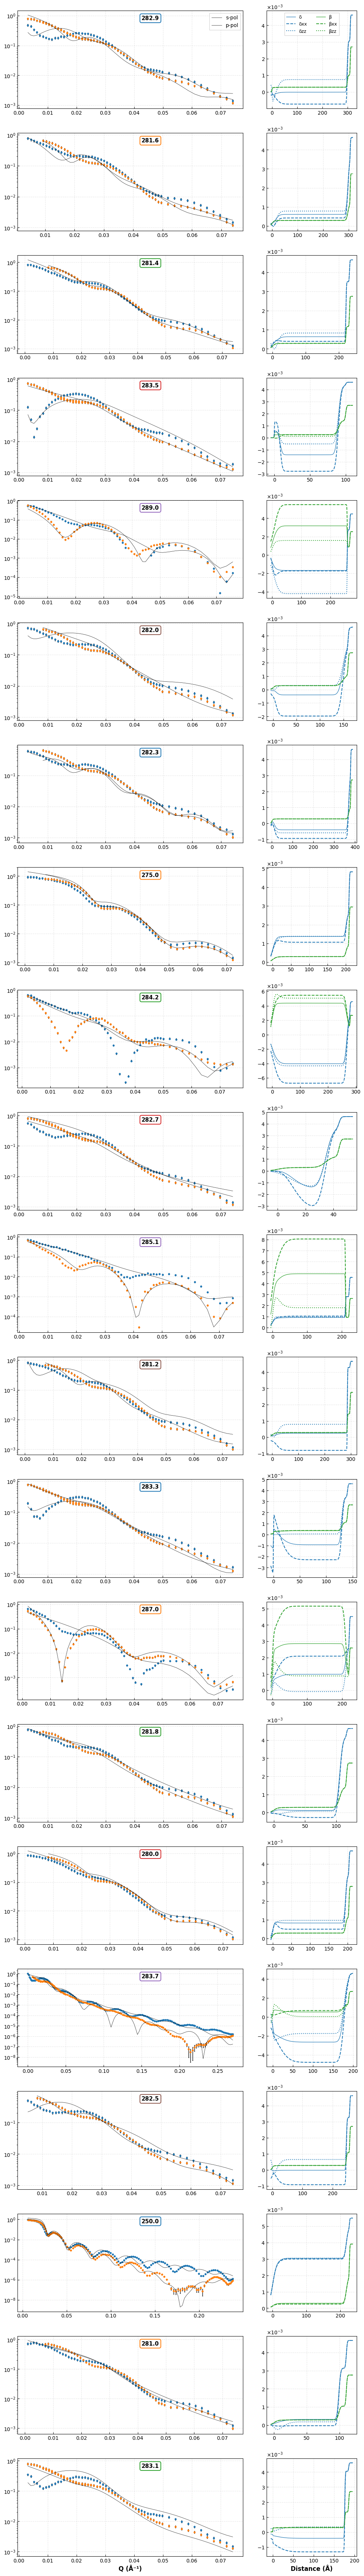

In [ ]:
plot_reflectivity_and_structure(fit_obj, figsize=(12, 4 * len(fit_obj.objectives)))
plt.show()